# 前期准备工作（环境准备）

## 本次作业只需要看 作业1.ipynb 和 作业2.ipynb 即可，其他的py文件都是由这两个文件衍生的。

## 在windows上安装Ubuntu-22.04（使用triton需要使用在linux上运行）

由于triton在windows没有可用的版本，考虑到大家都是使用的windows系统的比较多，这里附一个安装教程，有linux系统或者不想运行triton模块的同学可以跳过，如果在wsl的Linux环境准备有疑问可以参考视频[【Linux虚拟机】wsl+ubuntu+vscode配置教程](https://www.bilibili.com/video/BV17X3tehEAS/?spm_id_from=333.337.search-card.all.click&vd_source=048a80e0e2397a4a86eb91880a41bd02)

整个作业使用**linux或者ubuntu**进行，读者可以使用**windows的wsl**来在windows中跑通作本次作业是关于GPU和分布式训练的，如果有多个GPU就可以跑通，只有一个GPU也可以，但是就没有分布式训练的速度优势，但是作为教学学习是足够的。

如果您想使用自己作业1的实现，请将`cs336-basics`目录替换为您自己的实现，或编辑外层`pyproject.toml`文件以指向您自己的实现。

### 安装步骤

#### 1. 版本限制

我们需要在windows上安装wsl2，限制在Windows 10 2004 (19041) 及以上 或者 Windows 11 任意版本

#### 2.手动启用 WSL 相关功能（关键）

按住win键搜索**启用或者关闭windows功能**，找到并勾选 **于Linux的Windows子系统**和 **虚拟机平台**，点击确定


#### 3. 确认 CPU 虚拟化已开启

按住Ctrl + Shift + Esc打开任务管理器，性能 -> CPU ，右侧应显示：虚拟化：已启用

如果是“未启用”

需要进 BIOS / UEFI，开启：

Intel：Intel Virtualization Technology (VT-x)

AMD：SVM Mode

##### 4. 安装 Ubuntu

在windows搜索页面中输入CMD，并且以**管理员身份**运行

```bash
wsl --install -d Ubuntu
```

之后设置账号密码，**密码在输入的时候是不可见的**，看不到是正常的。

要打开ubuntu的命令行只需要在CMD命令行中输入

```bash
wsl
```

##### 5. 安装相关的工具 pip uv 等

依次执行
先使用管理员身份打开CMD

输入
```bash

cd $env:USERPROFILE
@"
[wsl2]
networkingMode=mirrored
dnsTunneling=true
autoProxy=true
firewall=true
"@ | Out-File -Encoding UTF8 .wslconfig


wsl --shutdown     # 彻底关掉虚拟机
wsl                # 再进子系统
```

```bash

sudo apt update
sudo apt install python3-pip

sudo apt install python3.12-venv

source ~/myenv/bin/activate
pip install uv -i https://pypi.tuna.tsinghua.edu.cn/simple
sudo ln -s /home/kangkang/myenv/bin/uv /usr/local/bin/uv

echo 'export UV_INDEX_URL=https://pypi.tuna.tsinghua.edu.cn/simple' >> ~/.bashrc

source ~/.bashrc

```

#### 6. 设置vscode的远程连接

打开vscode ，先搜索插件wsl。安装完成后打开左侧一列的远程连接就可以连接到wsl的ubuntu系统中


运行在CS336-Chinese-co-construction\coursework\Assignment2_System下
```bash
cd CS336-Chinese-co-construction\coursework\Assignment2_System
uv sync

. .venv/bin/activate
```
在vscode远程连接ubuntu，可以挂载在C盘或着D盘的项目文件，目录输入。

```bash
/mnt/c/  #后面接C盘目录

/mnt/d/ #后面接D盘目录

# 比如在本机中目录为"D:\code"，在ubuntu中就变成"/mnt/d/code"
```

也可以在Ubuntu的目录下克隆项目进行使用。


# 1. 基准测试和性能分析

# 作业一

（a）编写一个脚本，对模型的前向与反向传播进行基本的端到端基准测试。具体而言，你的脚本应支持以下功能：
- 给定超参数（例如层数），初始化一个模型。
- 生成一个随机批次的数据。
- 先运行 w 个预热步骤（开始计时之前），然后计时执行 n 个步骤（仅前向或同时包含前向与反向，取决于参数）。计时可使用 Python 的 timeit 模块（例如直接调用 timeit 函数，或使用 timeit.default_timer()，后者提供系统最高分辨率的时钟，比 time.time() 更适合基准测试）。
- 每一步之后调用 torch.cuda.synchronize()。

交付物：一个脚本，能够根据给定超参数初始化基础 Transformer 模型，创建随机数据批次，并对前向与反向传播进行计时。

（b）对 §1.2 中描述的模型规模，分别测试前向与反向传播耗时。  
使用 5 个预热步骤，并在 10 次测量步骤上计算平均耗时与标准差。  
一次前向传播耗时多久？反向传播呢？测量结果波动大吗，还是标准差很小？  

交付物：1–2 句话给出你的计时结果。

（c）基准测试的一个常见陷阱是跳过预热步骤。请在没有预热的情况下重复上述分析。结果如何变化？你认为原因是什么？再尝试仅使用 1 或 2 个预热步骤，为何结果仍可能不同？

## 首先检查GPU是否可用

这边通过pyproject.toml下载的torch是cpu版本
如果要安装GPU版本：
```bash
uv pip uninstall torch 
uv pip install torch --index-url https://download.pytorch.org/whl/cu121
```
cu121是我的cuda版本为12.1，可以改为自己的cuda版本

In [5]:
# 基础 Transformer 语言模型实现
from cs336_basics.model import BasicsTransformerLM 
# 获取 cosine learning rate schedule 的工具函数
from cs336_basics.optimizer import get_cosine_lr
# 自定义实现的 AdamW 优化器（可能用于教学或实验）
from cs336_basics.optimizer import AdamW
# 从数据集中取 batch 的工具函数
from cs336_basics.data import get_batch

import torch
import time
from typing import Callable
import torch.nn.functional as F


# 打印当前 PyTorch 版本
# 不同版本在 API、性能和后端支持上可能存在差异
print("Torch version:", torch.__version__)

# 检查是否可以使用 CUDA（NVIDIA GPU）
# 这是大多数深度学习训练中最关键的加速方式
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    # 当前机器上可用的 CUDA 设备数量
    # 多卡训练（DDP / FSDP）时非常重要
    print("CUDA device count:", torch.cuda.device_count())

    # 当前进程正在使用的 CUDA 设备 ID
    # 通常在多进程训练中由 local_rank 决定
    print("Current device:", torch.cuda.current_device())

    # 打印第 0 张 GPU 的名称
    # 有助于确认运行环境是否符合预期
    print("Device name:", torch.cuda.get_device_name(0))
else:
    # 如果没有检测到 CUDA GPU
    # 训练将只能在 CPU 或其他后端上进行，性能会显著下降
    print("No CUDA GPU detected")

# 检查是否支持 Apple 的 MPS（Metal Performance Shaders）后端
# 适用于 Apple Silicon（M1 / M2 / M3）设备
# 注意：MPS 的算子覆盖和数值稳定性可能与 CUDA 不完全一致
print(
    "MPS（苹果的 MPS） available:",
    hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
)


Torch version: 2.9.1+cu128
CUDA available: True
CUDA device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU
MPS（苹果的 MPS） available: False


In [7]:
def mean(values: list[float]) -> float:
    if not values:
        raise ValueError("mean() requires at least one value")
    return sum(values) / len(values)

def benchmark(description: str, run: Callable, num_warmups: int = 1, num_trials: int = 3):
    """Benchmark `func` by running it `num_trials`, and return all the times."""
    # 热身：第一次运行可能较慢,因为要编译和缓存
    # 我们将多次要运行内核，因为重要的是稳态的运行时间。
    for _ in range(num_warmups):
        run()
    if torch.cuda.is_available():
        torch.cuda.synchronize()  # 等待 CUDA 线程完成（非常重要！）
    print('现在真正计时!')
    times: list[float] = [] # @inspect times, @inspect description

    for trial in range(num_trials):  # 多次重复
        start_time = time.time()
        run()  # 实际执行计算
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # 等待 CUDA 线程 完成同步
        end_time = time.time()
        times.append((end_time - start_time) * 1000) # @inspect times
    mean_time = mean(times) # 多次测量取平均

    print(f'单次耗时：{mean_time  }ms')
    return mean_time 

现在来测试一下sleep函数


In [8]:
benchmark("sleep", lambda : time.sleep(50 / 1000))

现在真正计时!
单次耗时：50.158023834228516ms


50.158023834228516

在误差范围之内

我们来实测一下transformer

In [9]:
import numpy as np
import torch
import torch.nn.functional as F
import gc


def lm_loss(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    语言模型（Language Model）的标准 Cross Entropy Loss

    参数说明：
    - logits: 模型输出，形状为 (B, T, V)
        B: batch size
        T: 序列长度（context length）
        V: 词表大小（vocab size）
    - targets: 目标 token id，形状为 (B, T)

    训练目标：
    - 对每一个时间步 t，预测下一个 token 的概率分布
    """

    # 从 logits 中解析出 batch、序列长度、词表大小
    B, T, V = logits.shape

    # CrossEntropyLoss 要求输入为：
    # - logits: (N, C)
    # - targets: (N,)
    # 因此需要将 (B, T, V) 展平为 (B*T, V)
    return F.cross_entropy(
        logits.view(B * T, V),
        targets.view(B * T),
    )


def run_model(num_steps=1):
    """
    Transformer 语言模型的完整训练 + benchmark 单次运行函数

    包含：
    - 模型构建
    - 学习率调度
    - 前向 / 反向传播
    - 参数更新
    - 显存清理

    该函数会被 benchmark 工具多次调用
    """

    # =========================
    # 学习率调度相关超参数
    # =========================

    min_lr = 3e-5                    # 最小学习率（cosine 衰减下限）
    max_lr = 3e-4                    # 最大学习率（warmup 后峰值）
    warmup_iters = 200               # warmup 步数
    cosine_cycle_iters = 10_000      # 一个 cosine 周期的长度

    # =========================
    # 训练流程相关参数
    # =========================

    num_steps = 10                   # 总训练 step 数（benchmark 用，较小）
    batch_size = 32                  # batch size
    vocab_size = 50_000              # 词表大小
    context_length = 128             # 上下文长度（序列长度）

    # =========================
    # Transformer 模型结构参数
    # =========================

    d_model = 512                    # embedding / hidden size
    num_layers = 6                   # Transformer block 数量
    num_heads = 8                    # 多头注意力 head 数
    d_ff = 2048                      # FFN 中间层维度
    rope_theta = 10000.0             # RoPE（旋转位置编码）的 theta 参数

    # =========================
    # 设备选择
    # =========================

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print('使用设备：', device)
    # =========================
    # 主训练循环
    # =========================

    for it in range(num_steps):

        # 构造一个简单的 toy dataset（token id 序列）
        # 实际项目中通常来自 tokenizer + 语料
        dataset = np.arange(1000, dtype=np.int64)

        # =========================
        # 模型构建
        # =========================

        model = BasicsTransformerLM(
            vocab_size=vocab_size,
            context_length=context_length,
            d_model=d_model,
            num_layers=num_layers,
            num_heads=num_heads,
            d_ff=d_ff,
            rope_theta=rope_theta,
        ).to(device)

        # =========================
        # 优化器构建
        # =========================

        optimizer = AdamW(
            model.parameters(),
            lr=max_lr,                # 初始 lr，会在后面被 scheduler 覆盖
            weight_decay=0.1,
        )

        # =========================
        # 1 更新学习率（每 step）
        # =========================

        # 使用 cosine + warmup 的学习率调度策略
        lr = get_cosine_lr(
            it=it,
            max_learning_rate=max_lr,
            min_learning_rate=min_lr,
            warmup_iters=warmup_iters,
            cosine_cycle_iters=cosine_cycle_iters,
        )

        # 手动更新 optimizer 中的 lr
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        # =========================
        # 2 取一个 batch 的训练数据
        # =========================

        # x: 输入 token id，形状 (B, T)
        # y: 目标 token id，形状 (B, T)
        x, y = get_batch(
            dataset=dataset,
            batch_size=batch_size,
            context_length=context_length,
            device=device,
        )

        # =========================
        # 3 前向传播
        # =========================

        # logits 形状为 (B, T, V)
        logits = model(x)

        # =========================
        # 4 计算 loss
        # =========================

        loss = lm_loss(logits, y)

        # =========================
        # 5 反向传播
        # =========================

        # 清空梯度（set_to_none=True 可略微节省显存）
        optimizer.zero_grad(set_to_none=True)

        # 计算梯度
        loss.backward()

        # （可选但强烈推荐）
        # 梯度裁剪，防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # =========================
        # 6 更新参数
        # =========================

        optimizer.step()

    # =========================
    # 7 日志打印
    # =========================

        if it % 2 == 0:
            print(
            f"step {it:6d} | "
            f"loss {loss.item():.4f} | "
            f"lr {lr:.2e}"
        )

    # =========================
    # 显存 / 内存清理（benchmark 非常重要）
    # =========================

    try:
        # 主动删除大对象引用，避免显存堆积
        del model, x, y, logits, loss, lr, optimizer
    except NameError:
        pass

    # 清空 CUDA 缓存（不等价于释放显存，但可缓解碎片）
    torch.cuda.empty_cache()

    # 触发 Python 垃圾回收
    gc.collect()


# =========================
# 基准测试（benchmark）
# =========================

benchmark(
    description='transformer模型的基准测试',
    run=run_model,
    num_warmups=2,       # 预热次数（避免首次 CUDA 编译影响）
    num_trials=10,       # 正式测试次数
)


使用设备： cuda
step      0 | loss 10.8277 | lr 0.00e+00
step      2 | loss 10.8366 | lr 3.00e-06
step      4 | loss 10.8351 | lr 6.00e-06
step      6 | loss 10.8371 | lr 9.00e-06
step      8 | loss 10.8293 | lr 1.20e-05
使用设备： cuda
step      0 | loss 10.8265 | lr 0.00e+00
step      2 | loss 10.8293 | lr 3.00e-06
step      4 | loss 10.8335 | lr 6.00e-06
step      6 | loss 10.8317 | lr 9.00e-06
step      8 | loss 10.8278 | lr 1.20e-05
现在真正计时!
使用设备： cuda
step      0 | loss 10.8305 | lr 0.00e+00
step      2 | loss 10.8322 | lr 3.00e-06
step      4 | loss 10.8288 | lr 6.00e-06
step      6 | loss 10.8298 | lr 9.00e-06
step      8 | loss 10.8292 | lr 1.20e-05
使用设备： cuda
step      0 | loss 10.8262 | lr 0.00e+00
step      2 | loss 10.8234 | lr 3.00e-06
step      4 | loss 10.8329 | lr 6.00e-06
step      6 | loss 10.8365 | lr 9.00e-06
step      8 | loss 10.8304 | lr 1.20e-05
使用设备： cuda
step      0 | loss 10.8266 | lr 0.00e+00
step      2 | loss 10.8336 | lr 3.00e-06
step      4 | loss 10.8242 | lr 6.0

7694.176483154297

### 性能分析工具

使用wsl后无法测量cuda时间，这是正常现象，可以使用正常的linux系统或者windows系统，原因在于wsl的linux无法使用torch的一些接口(CUPTI)来检测cuda

In [8]:
import torch, ctypes, os
print('torch:', torch.__version__)
print('cuda :', torch.version.cuda)
try:
    ctypes.CDLL('libcupti.so')
    print('CUPTI: OK')
except:
    print('CUPTI: NOT FOUND')

torch: 2.9.1+cu128
cuda : 12.8
CUPTI: NOT FOUND


In [10]:
from torch.profiler import ProfilerActivity
import os
import torch
from typing import Callable


def profile(
    description: str,
    run: Callable,
    num_warmups: int = 1,
    with_stack: bool = False,
):
    """
    使用 PyTorch Profiler 对指定函数进行性能分析（CPU + CUDA）

    参数说明：
    - description:
        本次 profiling 的描述信息，用于区分不同实验
    - run:
        被 profiling 的函数（通常是一次完整的训练 step / forward-backward）
    - num_warmups:
        预热次数，用于消除首次运行带来的额外开销
    - with_stack:
        是否记录 CUDA 调用的 Python/C++ 堆栈信息（用于火焰图分析）
    """

    # =========================
    # 1 预热阶段（Warmup）
    # =========================

    # 预热的目的：
    # - 触发 CUDA kernel 的 JIT / lazy init
    # - 初始化 cuDNN / allocator
    # - 避免首次运行严重拉高 profiling 数据
    for _ in range(num_warmups):
        run()

    # =========================
    # 2 确认运行设备并同步
    # =========================

    if torch.cuda.is_available():
        print("正在使用 cuda")

        # CUDA 操作是异步的
        # 在 profiling 或计时前必须 synchronize，
        # 否则会统计到尚未完成的 kernel
        torch.cuda.synchronize()
    else:
        print("正在使用 cpu")

    # =========================
    # 3 使用 PyTorch Profiler 进行性能分析
    # =========================

    with torch.profiler.profile(
        # 指定需要分析的设备类型
        # 同时开启 CPU 和 CUDA
        activities=[
            ProfilerActivity.CPU,
            ProfilerActivity.CUDA,
        ],

        # 是否记录 Python / C++ 的调用栈
        # 用于后续生成火焰图或 stack trace
        with_stack=with_stack,

        # 实验性配置：
        # verbose=True 会输出更详细的 profiling 信息
        experimental_config=torch._C._profiler._ExperimentalConfig(
            verbose=True
        ),
    ) as prof:

        # 在 profiler 作用域内运行被测函数
        run()

        # 再次同步，确保所有 CUDA kernel 完全执行完毕
        if torch.cuda.is_available():
            torch.cuda.synchronize()

    # =========================
    # 4 生成并格式化 profiling 结果表格
    # =========================

    table = prof.key_averages().table(
        # 按 CUDA 自身耗时排序（不包含子算子）
        sort_by="self_cuda_time_total",

        # 算子名称列的最大宽度
        max_name_column_width=80,

        # 最多显示的行数
        row_limit=10,

        # 是否只显示顶层算子
        # False 表示展开所有子算子
        top_level_events_only=False,
    )

    # =========================
    # 5 导出 CUDA 调用栈（用于可视化）
    # =========================

    if with_stack:
        # 创建输出目录
        os.makedirs("var", exist_ok=True)

        # 文本形式的 stack trace
        text_path = f"var/stacks_{description}.txt"

        # 火焰图（可用于 speedscope / flamegraph）
        svg_path = f"var/stacks_{description}.svg"

        # 按 self_cuda_time_total 导出 stack
        prof.export_stacks(text_path, "self_cuda_time_total")

    # 返回 profiling 表格（字符串）
    return table


# =========================
# 实际执行 profiling
# =========================

print(
    profile(
        description='transformer',
        run=run_model,
        num_warmups=3,
        with_stack=True,
    )
)


使用设备： cuda
step      0 | loss 10.8249 | lr 0.00e+00
step      2 | loss 10.8265 | lr 3.00e-06
step      4 | loss 10.8285 | lr 6.00e-06
step      6 | loss 10.8351 | lr 9.00e-06
step      8 | loss 10.8334 | lr 1.20e-05
使用设备： cuda
step      0 | loss 10.8362 | lr 0.00e+00
step      2 | loss 10.8311 | lr 3.00e-06
step      4 | loss 10.8292 | lr 6.00e-06
step      6 | loss 10.8286 | lr 9.00e-06
step      8 | loss 10.8280 | lr 1.20e-05
使用设备： cuda
step      0 | loss 10.8305 | lr 0.00e+00
step      2 | loss 10.8216 | lr 3.00e-06
step      4 | loss 10.8385 | lr 6.00e-06
step      6 | loss 10.8316 | lr 9.00e-06
step      8 | loss 10.8317 | lr 1.20e-05
正在使用 cuda
使用设备： cuda
step      0 | loss 10.8321 | lr 0.00e+00
step      2 | loss 10.8295 | lr 3.00e-06
step      4 | loss 10.8299 | lr 6.00e-06
step      6 | loss 10.8306 | lr 9.00e-06
step      8 | loss 10.8322 | lr 1.20e-05
--------------------------------------------------------------------------------  ------------  ------------  ------------  --

# 作业二

然而，简单地将模型转换为低精度格式可能会导致模型精度降低。例如，许多梯度值在实践中太小，无法用 FP16 表示，因此在用 FP16 精度进行简单训练时会变成零。为了解决这个问题，通常在用 FP16 训练时使用损失缩放（loss is simply multiplied by a scaling factor, increasing gradient magnitudes so they don't flush to zero）。此外，FP16 的动态范围比 FP32 低，这可能导致溢出，表现为 NaN 损失。全精度（Full bfloat16）训练通常更稳定（因为 BF16 具有与 FP32 相同的动态范围），但与 FP32 相比仍可能影响最终模型性能。

为了利用低精度数据类型的加速优势，通常使用混合精度训练。在 PyTorch 中，这通过 torch.autocast 上下文管理器实现。在这种情况下，某些操作（例如矩阵乘法）在低精度数据类型上执行，而需要 FP32 全动态范围的操作（例如累积和归约）保持不变。例如，以下代码将自动识别在前向传播期间需要在低精度上执行的操作，并将这些操作转换为指定的数据类型：

```python
model : torch.nn.Module = ...  # 例如，你的 Transformer 模型
dtype : torch.dtype = ...  # 例如，torch.float16
x : torch.Tensor = ...  # 输入数据

with torch.autocast(device="cuda", dtype=dtype):
    y = model(x)
```

如上所述，即使张量本身已被降级，通常最好在高精度下保持累积。以下练习将帮助你建立直觉，了解为什么会这样。

问题（混合精度累积）：1 分

运行以下代码并评论结果的准确性。

```python
s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float32)
print(s)

s = torch.tensor(0, dtype=torch.float16)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float16)
print(s)

s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float16)
print(s)

s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    x = torch.tensor(0.01, dtype=torch.float16)
    s += x.type(torch.float32)
print(s)
```

交付物：2–3 句话的回应。

我们现在将混合精度应用于一个玩具模型进行直观理解.

In [2]:
import torch
import gc
s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float32)
print(s)

s = torch.tensor(0, dtype=torch.float16)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float16)
print(s)

s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float16)
print(s)

s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    x = torch.tensor(0.01, dtype=torch.float16)
    s += x.type(torch.float32)
print(s)


#  清理显存引用
try:
    del s, x,i
except NameError:
    pass
torch.cuda.empty_cache()
gc.collect()

tensor(10.0001)
tensor(9.9531, dtype=torch.float16)
tensor(10.0021)
tensor(10.0021)


754

可以看到全精度最准确，半进度最不准确，混合精度介于二者之间

# 作业三

问题（benchmarking_mixed_precision）：2 分

（a）考虑以下模型：

```python
class ToyModel(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 10, bias=False)
        self.ln = nn.LayerNorm(10)
        self.fc2 = nn.Linear(10, out_features, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.ln(x)
        x = self.fc2(x)
        return x
```

假设我们在 GPU 上训练模型，并且模型参数最初是 FP32。我们希望使用 FP16 的自动混合精度。上述列出的每个组件的数据类型是什么？

- autocast 上下文内的模型参数，
- 第一个前馈层（ToyModel.fc1）的输出，
- 层归一化（ToyModel.ln）的输出，
- 模型的预测 logits，
- 损失，
- 以及模型的梯度？

交付物：上述列出的每个组件的数据类型。

（b）你应该已经看到，FP16 混合精度自动转换对层归一化层的处理与前馈层不同。层归一化的哪些部分对混合精度敏感？如果我们使用 BF16 而不是 FP16，是否仍需要对层归一化进行不同处理？为什么或为什么不？

交付物：2–3 句话的回应。

（c）修改你的基准测试脚本，以便可以选择使用 BF16 混合精度运行模型。对 §1.1.2 中描述的每种语言模型规模，分别计时使用和不使用混合精度的前向和反向传播。比较使用全精度与混合精度的结果，并评论模型大小变化时的任何趋势。你可能会发现无上下文的 no-op 上下文管理器很有用。

交付物：2–3 句话的回应，包含你的计时结果和评论。

## 一个简单的解答

首先模型参数 **存储 dtype 不变**（仍是 FP32），autocast 只影响 **算子内部计算与中间张量**，反向传播中梯度通常以 **FP32 累积**。

**`autocast`** 是 PyTorch 中用于 **自动混合精度（Automatic Mixed Precision, AMP）** 的上下文管理器，用来在 **不改模型代码的情况下**，自动为不同算子选择合适的数据类型（FP32 / FP16 / BF16），从而 **加速计算并减少显存占用，同时尽量保持数值稳定性**。


当你写：

```python
with torch.cuda.amp.autocast():
    y = model(x)
    loss = criterion(y, target)
```

`autocast` 会在 **前向传播阶段** 完成以下：

不同算子用不同精度计算：**线性层 / 卷积 / matmul** 会用 **FP16 / BF16**（速度快、Tensor Core 友好），而**LayerNorm / Softmax / 指数、除法等数值敏感算子**会使用 **FP32**（保证数值稳定）。

但参数本身不被永久转换，`model.parameters()` 仍是 **FP32**，autocast 只在 **算子执行时临时 cast**。

中间激活自动使用低精度，激活张量通常是 FP16 / BF16，显存占用会有明显降低。

---

常见使用：

```python
with torch.cuda.amp.autocast(dtype=torch.float16):
    ...
```

速度快，但是需要 `GradScaler`，对 LayerNorm / Softmax 非常敏感。GradScaler 是 PyTorch 自动混合精度（AMP）中 专门为 FP16 训练服务的梯度缩放器，作用只有一个：防止 FP16 反向传播时梯度下溢（underflow）。torch.cuda.amp.GradScaler 在 反向传播前 把 loss 放大一个比例因子（scale），使梯度落在 FP16 能表示的数值范围内，

```
loss        → loss × scale
grad        → grad × scale
optimizer   → 自动除以 scale

```

```python
with torch.cuda.amp.autocast(dtype=torch.bfloat16):
    ...
```

指数位与 FP32 相同，**数值稳定**。通常 **不需要 GradScaler**，在 Ampere+ GPU 上支持良好。


### 问题 (a)

在自动混合精度（Autocast）下，使用 FP16 训练时，各组件的数据类型如下：

- **模型参数（model parameters）**：由于模型参数最初是 FP32，它们在 autocast 上下文内保持为 FP32。
- **第一个前馈层的输出（output of the first feed-forward layerToyModel.fc1）**：在 autocast 上下文中，该层的输出将被转换为 FP16。
- **层归一化的输出（output of layer norm ToyModel.ln）**：层归一化层的输出通常保持为 FP32，因为层归一化需要较高的数值稳定性，FP16 的动态范围较小，可能导致数值不稳定。
- **模型的预测 logits**：在 autocast 上下文中，这些 logits 将被转换为 FP16。
- **损失（loss）**：损失计算通常在 FP32 中进行，以保持数值稳定性。
- **模型的梯度（model's gradients）**：梯度通常也保持为 FP32，以确保优化过程的稳定性。

### 问题 (b)

层归一化对混合精度的敏感性主要体现在其计算过程中需要较高的数值精度。层归一化涉及到均值和方差的计算，这些计算在 FP16 中可能会因为数值范围的限制而导致不准确，从而影响模型的训练效果。因此，即使在 FP16 混合精度下，层归一化通常也需要保持在 FP32 中进行，以确保数值稳定性。

如果我们使用 BF16 而不是 FP16，我们可能仍然需要对层归一化进行特殊处理。BF16 虽然在动态范围上与 FP32 相同，但其精度较低，可能仍然不足以保证层归一化计算的稳定性。因此，为了保持数值稳定性，层归一化可能仍然需要在 FP32 中进行。

### 问题c

运行以下代码




In [11]:
import torch
import torch.nn as nn
import time
import gc
from contextlib import nullcontext
from my_profile import profile


class ToyModel(nn.Module):
    """
    用于性能测试的简单前馈网络（Toy Model）

    结构：
    Linear (无 bias)
      → ReLU
      → LayerNorm
      → Linear (无 bias)

    设计目的：
    - 结构足够简单，便于观察算子性能
    - 同时包含：
        - GEMM（Linear）
        - 非线性（ReLU）
        - 归一化（LayerNorm）
    """

    def __init__(self, in_features, out_features):
        super().__init__()

        # 第一层全连接：in_features → 1024
        self.fc1 = nn.Linear(in_features, 1024, bias=False)

        # LayerNorm：对最后一维做归一化
        self.ln = nn.LayerNorm(1024)

        # 第二层全连接：1024 → out_features
        self.fc2 = nn.Linear(1024, out_features, bias=False)

        # ReLU 激活函数
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        前向传播

        张量形状：
        - 输入 x: (B, in_features)
        - 输出: (B, out_features)
        """
        x = self.relu(self.fc1(x))
        x = self.ln(x)
        x = self.fc2(x)
        return x


def benchmark_dtype_fp32(use_bf16=False, iters=1000):
    """
    FP32 精度下的前向推理性能 benchmark

    参数说明：
    - use_bf16:
        是否开启 bfloat16 autocast（此函数默认 False）
    - iters:
        实际测量的迭代次数
    """

    device = "cuda"

    # 构建模型并移动到 GPU
    model = ToyModel(1024, 1024).to(device)

    # 构造输入张量（batch=256）
    x = torch.randn(256, 1024, device=device)

    # 根据 use_bf16 决定是否启用 autocast
    # - FP32：nullcontext（什么都不做）
    # - BF16：torch.autocast
    autocast_ctx = (
        torch.autocast(device_type="cuda", dtype=torch.bfloat16)
        if use_bf16 else nullcontext()
    )

    # =========================
    # warmup 阶段
    # =========================

    # 触发 CUDA kernel 初始化、cudnn autotune 等
    for _ in range(10):
        with autocast_ctx, torch.no_grad():
            _ = model(x)

    # 同步，确保 warmup 完成
    torch.cuda.synchronize()

    # =========================
    # 正式计时
    # =========================

    start = time.time()

    for _ in range(iters):
        with autocast_ctx, torch.no_grad():
            _ = model(x)

    # 等待所有 CUDA kernel 执行完成
    torch.cuda.synchronize()
    end = time.time()

    return end - start


def benchmark_dtype_bf16(use_bf16=True, iters=1000):
    """
    BF16 混合精度下的前向推理性能 benchmark

    与 FP32 版本逻辑完全一致
    唯一区别：默认开启 bfloat16 autocast
    """

    device = "cuda"

    model = ToyModel(1024, 1024).to(device)
    x = torch.randn(256, 1024, device=device)

    autocast_ctx = (
        torch.autocast(device_type="cuda", dtype=torch.bfloat16)
        if use_bf16 else nullcontext()
    )

    # warmup
    for _ in range(10):
        with autocast_ctx, torch.no_grad():
            _ = model(x)

    torch.cuda.synchronize()
    start = time.time()

    for _ in range(iters):
        with autocast_ctx, torch.no_grad():
            _ = model(x)

    torch.cuda.synchronize()
    end = time.time()

    return end - start


# =========================
# 实际运行 benchmark
# =========================

fp32_time = benchmark_dtype_fp32(use_bf16=False)
bf16_time = benchmark_dtype_bf16(use_bf16=True)

print(f"FP32 time: {fp32_time:.4f}s")
print(f"BF16 time: {bf16_time:.4f}s")

# =========================
# 使用 PyTorch Profiler 进行算子级性能分析
# =========================

print(
    profile(
        description='benchmark_dtype_fp32',
        run=benchmark_dtype_fp32,
        num_warmups=3,
    )
)

print(
    profile(
        description='benchmark_dtype_bf16',
        run=benchmark_dtype_bf16,
        num_warmups=3,
    )
)


FP32 time: 0.3536s
BF16 time: 0.1905s
正在使用 cuda
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                        aten::mm        16.75%      24.307ms        37.50%      54.431ms      26.946us     154.984ms        95.61%     154.984ms      76.725us          2020  
                                                          a

可以看到不同精度下，精度越低则速度越快，在比较使用全精度（FP32）与混合精度（BF16）的结果时，我们可能会观察到 BF16 在某些情况下可以提供与 FP32 相似的精度，同时显著减少内存使用和加速计算。然而，对于需要高精度计算的层（如层归一化），BF16 可能不如 FP32 稳定。随着模型大小的变化，我们可能会看到不同规模的模型对混合精度的敏感性不同，这需要在实际应用中进行具体分析和调整。

# 作业四


到目前为止，我们一直在关注计算性能。现在我们将把注意力转向**内存**，这是语言模型训练和推理中的另一项关键资源。
PyTorch 也提供了一个强大的**内存分析器（memory profiler）**，可以随时间跟踪内存分配情况。

要使用内存分析器，你可以按如下方式修改你的 benchmark 脚本：

```
7
```

---

```python
# ... 在你的 benchmarking 脚本中的 warm-up 阶段

# 开始记录内存历史
torch.cuda.memory._record_memory_history(max_entries=1000000)

# ... 在你的 benchmarking 脚本中你想要分析的部分

# 保存一个 pickle 文件，用于 PyTorch 的在线工具加载
torch.cuda.memory._dump_snapshot("memory_snapshot.pickle")

# 停止记录内存历史
torch.cuda.memory._record_memory_history(enabled=None)
```

这将输出一个名为 `memory_snapshot.pickle` 的文件，你可以将其加载到如下在线工具中：
[https://pytorch.org/memory_viz](https://pytorch.org/memory_viz)
该工具可以让你查看整体内存使用时间线，以及每一次独立的内存分配是如何发生的，包括其大小以及指向分配来源代码位置的调用栈追踪。

要使用该工具，你应当在浏览器中打开上述链接，然后将你的 pickle 文件拖拽到页面中。

现在你将使用 PyTorch profiler 来分析你模型的内存使用情况。

---

### Problem（memory profiling）：4 分

| Size | d_model | d_ff | num_layers | num_heads |
|------|---------|------|------------|-----------|
| small | 768 | 3072 | 12 | 12 |
| medium | 1024 | 4096 | 24 | 16 |
| large | 1280 | 5120 | 36 | 20 |
| xl | 1600 | 6400 | 48 | 25 |
| 2.7B | 2560 | 10240 | 32 | 32 |
对 **表 1 中的 2.7B 模型**进行 profiling，分析其 **前向传播（forward pass）**、**反向传播（backward pass）** 以及 **优化器步骤（optimizer step）**，上下文长度分别为 **128、256 和 512**。

---

**(a)**
在你的 profiling 脚本中加入一个选项，使模型运行时能够经过内存分析器。
你可能需要复用之前的一些基础设施（例如：激活 mixed-precision、加载特定的模型大小等）。

然后，在以下两种情况下，为 2.7B 模型获取内存 profile：

* 只做推理（仅前向传播）
* 完整训练一步（前向 + 反向 + 优化器步骤）

你的内存时间线看起来如何？你能否根据看到的峰值判断当前运行的是哪个阶段？

**Deliverable：**
来自 `pytorch.org/memory_viz` 工具中 **“Active Memory Timeline”** 的两张截图（针对 context length = 512）：

* 一张是仅前向传播
* 一张是完整训练步骤（前向和反向传播，不含 optimizer step），
  并附上一段 **2–3 句**的文字说明。

---

**(b)**
在仅进行前向传播时，不同 context length 下的峰值内存使用是多少？
在执行完整训练步骤时又是多少？

**Deliverable：**
一张表格，每个 context length 对应两个数值。

---

**(c)**
在使用 **mixed-precision** 的情况下，找出 2.7B 模型在以下两种情形下的峰值内存使用：

* 前向传播
* 完整优化器步骤

Mixed-precision 是否显著影响了内存使用？

**Deliverable：**
一段 **2–3 句**的文字说明。

---

**(d)**
考虑 2.7B 模型。给定我们的参考超参数，在 **single-precision** 下，
Transformer 残差流（residual stream）中 **激活张量（activations）** 的大小是多少？

请以 **MB** 为单位给出结果（即用字节数除以 (1024^2)）。

**Deliverable：**
一段 **1–2 句**的回答，并给出你的推导过程。

---

**(e)**
仔细查看 `pytorch.org/memory_viz` 中，2.7B 模型在前向传播时的 **“Active Memory Timeline”**。

当你将 **“Detail”** 级别调低时，工具会显示最小分配的快照
（例如，将 “Detail” 调到 **10%**，表示展示 **10% 最大的分配**）。

最大的分配大小是多少？
查看其调用栈（stack trace），你能判断这些分配来自哪里吗？

**Deliverable：**
一段 **1–2 句**的文字说明。



In [ ]:
from torch.profiler import ProfilerActivity
import torch
import os
from typing import Callable
def memory_profile(description: str, run: Callable, num_warmups: int = 1, with_stack: bool = False):
    # 预热
    for _ in range(num_warmups):
        run()
    if torch.cuda.is_available():
        print("正在使用cuda")
        torch.cuda.synchronize()  # 等待CUDA线程结束
    else:
        print('正在使用cpu')
    # 使用性能分析器运行代码
    
    with torch.profiler.profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            # 输出堆栈跟踪以进行可视化
            with_stack=with_stack,
            #  需要导出堆栈跟踪以进行可视化
            experimental_config=torch._C._profiler._ExperimentalConfig(verbose=True)) as prof:
        run()
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # 等待CUDA线程结束

    # warm-up（不记录）
    for _ in range(10):
        run()
    torch.cuda.synchronize()
    # 开始记录 CUDA 内存历史
    torch.cuda.memory._record_memory_history(
        max_entries=1000000
    )
    # ===== 被分析代码 =====
    run()
    torch.cuda.synchronize()
    # =====================
    # 导出快照
    torch.cuda.memory._dump_snapshot("memory_snapshot.pickle")
    # 停止记录
    torch.cuda.memory._record_memory_history(enabled=None)


    # 打印表格
    table = prof.key_averages().table(
        sort_by="self_cuda_time_total",
        max_name_column_width=80,
        row_limit=10,
        top_level_events_only=False) 
    #text(f"## {description}")
    #text(table, verbatim=True)
    # Write stack trace visualization
    if with_stack:
        os.makedirs("var", exist_ok=True)
        text_path = f"var/stacks_{description}.txt"
        svg_path = f"var/stacks_{description}.svg"
        prof.export_stacks(text_path, "self_cuda_time_total")
    return table



In [14]:
from cs336_basics.optimizer import AdamW, get_cosine_lr
from cs336_basics.model import BasicsTransformerLM
from cs336_basics.data import get_batch
import torch.nn.functional as F
import numpy as np
def lm_loss(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # logits: (B, T, V)
        # targets: (B, T)
        B, T, V = logits.shape
        return F.cross_entropy(
            logits.view(B * T, V),
            targets.view(B * T),
        )
def run_model(num_steps = 1):
    vocab_size = 50_000
    context_length = 128
    batch_size = 32
    
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    rope_theta = 10000.0
    
    max_lr = 3e-4
    min_lr = 3e-5
    warmup_iters = 200
    cosine_cycle_iters = 10_000
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print('运行设备',device)
    model = BasicsTransformerLM(
        vocab_size=vocab_size,
        context_length=context_length,
        d_model=d_model,
        num_layers=num_layers,
        num_heads=num_heads,
        d_ff=d_ff,
        rope_theta=rope_theta,
    ).to(device)
    
    optimizer = AdamW(
        model.parameters(),
        lr=max_lr,
        weight_decay=0.1,
    )
    for it in range(num_steps):
        #print(f'{it}/{num_steps}')
        # 1️更新学习率（每 step）
        lr = get_cosine_lr(
            it=it,
            max_learning_rate=max_lr,
            min_learning_rate=min_lr,
            warmup_iters=warmup_iters,
            cosine_cycle_iters=cosine_cycle_iters,
        )
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        dataset = np.arange(1000, dtype=np.int64)
        # 2取 batch
        x, y = get_batch(
            dataset=dataset,
            batch_size=batch_size,
            context_length=context_length,
            device=device,
        )
        #print(x)

        # 3前向
        logits = model(x)

        # 4loss
        loss = lm_loss(logits, y)

        # 5反向
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        
        # （可选）梯度裁剪（强烈推荐）
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 6更新参数
        optimizer.step()
        #  清理显存引用
        try:
            del X, attention_fn, out, loss
        except NameError:
            pass
            torch.cuda.empty_cache()
            gc.collect()
    # 7日志
    if it % 100 == 0:
        print(
            f"step {it:6d} | "
            f"loss {loss.item():.4f} | "
            f"lr {lr:.2e}"
        )



In [13]:
print(memory_profile(description="前向传播",run=run_model))

step      0 | loss 10.8306 | lr 0.00e+00
正在使用cuda
step      0 | loss 10.8350 | lr 0.00e+00
step      0 | loss 10.8312 | lr 0.00e+00
step      0 | loss 10.8314 | lr 0.00e+00
step      0 | loss 10.8308 | lr 0.00e+00
step      0 | loss 10.8288 | lr 0.00e+00
step      0 | loss 10.8306 | lr 0.00e+00
step      0 | loss 10.8309 | lr 0.00e+00
step      0 | loss 10.8286 | lr 0.00e+00
step      0 | loss 10.8322 | lr 0.00e+00
step      0 | loss 10.8256 | lr 0.00e+00
step      0 | loss 10.8327 | lr 0.00e+00
step      0 | loss 10.8319 | lr 0.00e+00
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-----------

# Flash Attention 


# 作业 五

你的性能分析结果很可能表明，在注意力层中，无论是**内存**还是**计算**方面，都存在优化空间。从高层次来看，注意力操作由一次矩阵乘法、一次 softmax，然后再一次矩阵乘法组成：

$$
\mathrm{Attention}(Q, K, V) = \mathrm{softmax}\left(\mathrm{mask}\left(\frac{QK^\top}{\sqrt{d_k}}\right)\right)V
\tag{1}
$$

朴素的注意力实现需要为每个 batch / head 元素保存形状为

${seqlen} \times {seqlen}$ 的注意力分数矩阵。随着序列长度变长，这个矩阵会迅速变得非常大，从而在长输入或长输出任务中导致 **out-of-memory (OOM)** 错误。
我们将实现一个遵循 **FlashAttention-2** 论文的注意力 kernel，它通过 **按 tile 方式计算注意力**，避免显式地物化 ${seqlen} \times {seqlen}$ 的注意力分数矩阵，从而支持更长的序列长度。

---

### **Problem (pytorch_attention): 2 points**

#### (a) 在不同规模下对你的注意力实现进行基准测试。编写一个脚本来完成以下任务：

(a) 将 batch size 固定为 **8**，并且 **不使用多头注意力**（即移除 head 这一维）。

(b) 遍历如下笛卡尔积配置：

* head embedding 维度 $d_{\text{model}} \in {16, 32, 64, 128}$
* 序列长度 ${seqlen} \in {256, 1024, 4096, 8192, 16384}$

(c) 为对应的尺寸生成随机输入 (Q, K, V)。

(d) 使用这些输入，对注意力前向传播 **计时 100 次**。

(e) 测量在 **反向传播开始之前** 的显存使用量，并对 **反向传播计时 100 次**。

(f) 确保进行 **warm-up**，并在每次前向 / 反向传播之后调用
`torch.cuda.synchronize()`。

---

请报告你在这些配置下得到的 **时间结果（或 out-of-memory 错误）**。
**在什么规模下会出现 out-of-memory？**

请选择你发现的 **最小的、仍然会 OOM 的配置之一**，对注意力的内存使用进行详细的**显存占用核算**（你可以使用 Assignment 1 中 Transformer 内存使用的公式）。

* 反向传播中节省的显存会如何随着序列长度变化？
* 你会如何 **消除反向传播中的这部分内存开销**？

---

### **Deliverable（提交内容）**

* 一张包含 **时间测量结果** 的表格
* 你对 **内存使用的推导过程**
* 一段 **1–2 段的文字分析回答**




In [1]:
import torch
import torch.nn as nn
import math


class NaiveSelfAttention(nn.Module):
    """
    单头、朴素自注意力实现
    Attention(Q, K, V) = softmax(QK^T / sqrt(d)) V
    """

    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model

        # 线性投影（Q, K, V）
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, D)
        return: (B, T, D)
        """
        B, T, D = x.shape
        assert D == self.d_model

        # 1. 线性投影
        Q = self.q_proj(x)  # (B, T, D)
        K = self.k_proj(x)  # (B, T, D)
        V = self.v_proj(x)  # (B, T, D)

        # 2. 注意力分数 (B, T, T)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(D)

        # 3. softmax
        attn = torch.softmax(scores, dim=-1)  # (B, T, T)

        # 4. 加权求和
        out = torch.matmul(attn, V)  # (B, T, D)

        return out


In [1]:
import torch
import torch.nn as nn
import math
import time
import torch._inductor.config as inductor_config
import gc

# ========== 禁用 CUDA Graphs 避免 backward 错误 ==========
inductor_config.triton.cudagraphs = False
inductor_config.triton.cudagraph_trees = False
torch.set_float32_matmul_precision("high")

class NaiveSelfAttention(nn.Module):
    """
    单头、朴素自注意力实现
    Attention(Q, K, V) = softmax(QK^T / sqrt(d)) V
    """

    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model

        # 线性投影（Q, K, V）
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, D)
        return: (B, T, D)
        """
        B, T, D = x.shape
        assert D == self.d_model

        # 1. 线性投影
        Q = self.q_proj(x)  # (B, T, D)
        K = self.k_proj(x)  # (B, T, D)
        V = self.v_proj(x)  # (B, T, D)

        # 2. 注意力分数 (B, T, T)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(D)

        # 3. softmax
        attn = torch.softmax(scores, dim=-1)  # (B, T, T)

        # 4. 加权求和
        out = torch.matmul(attn, V)  # (B, T, D)

        return out


def benchmark_attention(device="cuda"):
    torch.manual_seed(0)

    batch_size = 8
    d_models = [16, 32, 64, 128]
    seqlens = [256, 1024, 4096, 8192, 16384]

    results = []

    for d_model in d_models:
        print(f"\n{'='*50}")
        print(f"Testing d_model={d_model}")
        print(f"{'='*50}")
        
        for seqlen in seqlens:
            try:
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
                
                # 构造输入（无多头）
                X = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True)
                
                # 创建模型
                attention_fn = NaiveSelfAttention(d_model=d_model).to(device).to(torch.float32)
                
                # warm-up：包含 forward + backward，并清零梯度
                for _ in range(10):
                    out = attention_fn(X)
                    loss = out.sum()
                    loss.backward()
                    attention_fn.zero_grad(set_to_none=True)
                
                torch.cuda.synchronize()

                # forward timing：需要创建计算图但不 backward
                torch.cuda.synchronize()
                start = time.perf_counter()
                for _ in range(10):
                    out = attention_fn(X)
                    _ = out.sum()  # 创建标量，但不 backward
                torch.cuda.synchronize()
                forward_time = (time.perf_counter() - start) / 10

                # 记录 forward 后的显存（peak memory）
                mem_allocated = torch.cuda.max_memory_allocated() / 1024**2

                # backward timing：完整的 forward + backward
                torch.cuda.synchronize()
                start = time.perf_counter()
                for _ in range(10):
                    out = attention_fn(X)
                    loss = out.sum()
                    loss.backward()
                    attention_fn.zero_grad(set_to_none=True)
                torch.cuda.synchronize()
                backward_time = (time.perf_counter() - start) / 10

                results.append({
                    "d_model": d_model,
                    "seqlen": seqlen,
                    "forward_time_ms": forward_time * 1000,
                    "backward_time_ms": backward_time * 1000,
                    "mem_MB": mem_allocated,
                })

                print(f"✓ T={seqlen:5d} | Fwd: {forward_time*1000:6.2f}ms | Bwd: {backward_time*1000:7.2f}ms | Mem: {mem_allocated:.1f}MB")

            except RuntimeError as e:
                if "out of memory" in str(e):
                    results.append({
                        "d_model": d_model,
                        "seqlen": seqlen,
                        "OOM": True
                    })
                    print(f"✗ T={seqlen:5d} | OOM")
                    torch.cuda.empty_cache()
                else:
                    raise e
          
            finally:
                # 清理显存引用
                try:
                    del X, attention_fn, out, loss
                except NameError:
                    pass
                torch.cuda.empty_cache()
                gc.collect()
                torch.cuda.empty_cache()
    
    return results

# 运行测试
results = benchmark_attention()


Testing d_model=16
✓ T=  256 | Fwd:   0.22ms | Bwd:    1.07ms | Mem: 25.0MB
✓ T= 1024 | Fwd:   1.05ms | Bwd:    2.80ms | Mem: 147.3MB
✓ T= 4096 | Fwd:  15.62ms | Bwd:   46.87ms | Mem: 2076.3MB
✓ T= 8192 | Fwd: 352.39ms | Bwd: 1400.97ms | Mem: 8232.3MB
✗ T=16384 | OOM

Testing d_model=32
✓ T=  256 | Fwd:   0.19ms | Bwd:    1.50ms | Mem: 8240.3MB
✓ T= 1024 | Fwd:   1.55ms | Bwd:    4.29ms | Mem: 8240.3MB
✓ T= 4096 | Fwd:  15.57ms | Bwd:   43.96ms | Mem: 8240.3MB
✓ T= 8192 | Fwd: 227.31ms | Bwd:  373.38ms | Mem: 8256.3MB
✗ T=16384 | OOM

Testing d_model=64
✓ T=  256 | Fwd:   0.30ms | Bwd:    1.36ms | Mem: 8272.3MB
✓ T= 1024 | Fwd:   0.98ms | Bwd:    2.96ms | Mem: 8272.3MB
✓ T= 4096 | Fwd:  15.02ms | Bwd:   44.85ms | Mem: 8272.3MB
✓ T= 8192 | Fwd: 235.51ms | Bwd:  759.53ms | Mem: 8304.3MB
✗ T=16384 | OOM

Testing d_model=128
✓ T=  256 | Fwd:   1.01ms | Bwd:    2.03ms | Mem: 8336.3MB
✓ T= 1024 | Fwd:   1.15ms | Bwd:    3.46ms | Mem: 8336.3MB
✓ T= 4096 | Fwd:  16.20ms | Bwd:   48.54ms | Mem

**已知输入张量形状**

```python
x.shape = [8, 8192, 16]
dtype = torch.float32  # 默认
```

* batch size (B = 8)
* sequence length (T = 8192)
* hidden dim (D = 16)
* float32 = **4 bytes**

---

**元素总数**

$$
8 \times 8192 \times 16 = 1{,}048{,}576 \text{ elements}
$$

---

**显存占用（仅 input x）**

$$
1{,}048{,}576 \times 4 \text{ bytes}
= 4{,}194{,}304 \text{ bytes}
\approx 4.0 \text{ MB}
$$

---


> **输入 `torch.Size([8, 8192, 16])` 本身仅占约 `4 MB` 显存**


真正爆显存的是注意力里的**attention score 矩阵**

```python
scores.shape = [8, 8192, 8192]
```

元素数：

$$
8 \times 8192^2 = 536{,}870{,}912
$$

显存：


$$
536{,}870{,}912 \times 4 \approx 2.0 \text{ GB}
$$

而且，scores 要存，softmax 输出要存，backward 还要再存一份中间量。



我们将在这里实现一个flash attention，我们需要实现两个部分，一个是分块，第二个是数值稳定softmax的方式，思想上非常接近 FlashAttention v1，具体可以看第六章：GPU和GPU相关的优化，有详细介绍


# 作业六
Problem (torch_compile): 2 points
------------------------------------------------------------

(a) 扩展你的 attention 基准测试脚本，
    加入你使用 PyTorch 实现的 attention 的
    **编译版本（compiled version）**，
    并在与上一个 pytorch_attention 问题
    相同的配置下，将其性能与未编译版本进行比较。

Deliverable：
    一张表格，对比你 **编译后的 attention 模块**
    与 **pytorch_attention 问题中未编译版本**
    在前向传播和反向传播上的耗时。

(b) 接下来，在端到端的基准测试脚本中，
    将你的整个 Transformer 模型进行编译。
    前向传播的性能会如何变化？
    那么 **前向 + 反向传播 + 优化器更新步骤**
    的整体性能又会如何变化？

Deliverable：
    一张表格，对比 **原始（vanilla）**
    与 **编译后（compiled）** 的 Transformer 模型。


In [1]:
import torch
import torch.nn as nn
import math
import time
import torch._inductor.config as inductor_config
import gc
inductor_config.triton.cudagraphs = False
# 同时禁用 cudagraph 相关的 tree reduction 优化
inductor_config.triton.cudagraph_trees = False


import torch._dynamo.config as dynamo_config
dynamo_config.recompile_limit = 32
torch.set_float32_matmul_precision("high")
TORCH_LOGS="recompiles"

class NaiveSelfAttention(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, D = x.shape
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(D)
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        return out

def benchmark_attention_fixed(device="cuda",d_models =[16, 32, 64, 128] ):
    torch.manual_seed(0)
    batch_size = 8
  
    seqlens = [256, 1024, 4096, 8192, 16384]
    
    results = []
    
    for d_model in d_models:
        print(f"\n{'='*40}")
        print(f"Testing d_model={d_model}")
        print(f"{'='*40}")
        
        # 关键修复：为每个 d_model 单独编译，避免跨 d_model 的重编译
        model = NaiveSelfAttention(d_model).to(device).to(torch.float32)
        
        # 修复：使用 max-autotune 模式获得更好性能，或 default 但接受重编译
        # 注意：d_model 变化必须重新编译，因为权重矩阵形状变了
        compiled_model = torch.compile(model, mode="default", dynamic=False)
        
        for seqlen in seqlens:
            try:
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
                
                # 创建输入
                X = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True)
                
                # Warm-up：固定 5 次，包含 forward + backward
                for _ in range(10):
                    out = compiled_model(X)
                    loss = out.sum()
                    loss.backward()
                    # 修复：必须清零梯度，否则累积
                    model.zero_grad(set_to_none=True)
                
                torch.cuda.synchronize()
                
                # Forward 计时（带梯度，与 backward 一致）
                torch.cuda.synchronize()
                start = time.perf_counter()
                for _ in range(10):
                    out = compiled_model(X)
                    # 修复：需要 retain_graph 否则第二次迭代 backward 会失败
                    # 或者每次重新创建计算图
                    loss = out.sum()
                torch.cuda.synchronize()
                forward_time = (time.perf_counter() - start) / 10
                
                # Backward 计时
                torch.cuda.synchronize()
                start = time.perf_counter()
                for _ in range(10):
                    out = compiled_model(X)
                    loss = out.sum()
                    loss.backward()
                    model.zero_grad(set_to_none=True)
                torch.cuda.synchronize()
                backward_time = (time.perf_counter() - start) / 10
                
                mem_allocated = torch.cuda.memory_allocated() / 1024**2
                
                results.append({
                    "d_model": d_model,
                    "seqlen": seqlen,
                    "forward_ms": forward_time * 1000,
                    "backward_ms": backward_time * 1000,
                    "total_ms": (forward_time + backward_time) * 1000,
                    "mem_MB": mem_allocated,
                })
                print(f"✓ T={seqlen:5d} | Fwd: {forward_time*1000:6.2f}ms | Bwd: {backward_time*1000:7.2f}ms | Mem: {mem_allocated:.1f}MB")
                
            except RuntimeError as e:
                if "out of memory" in str(e):
                    results.append({"d_model": d_model, "seqlen": seqlen, "OOM": True})
                    print(f"✗ T={seqlen:5d} | OOM")
                    torch.cuda.empty_cache()
                else:
                    raise e
            
            del X
            torch.cuda.empty_cache()
        
        del model, compiled_model
        gc.collect()
        torch.cuda.empty_cache()
    
    return results

# 运行

results = benchmark_attention_fixed(d_models=[16])
results = benchmark_attention_fixed(d_models=[32])
results = benchmark_attention_fixed(d_models=[64])
results = benchmark_attention_fixed(d_models=[128])


Testing d_model=16
✓ T=  256 | Fwd:   0.32ms | Bwd:    1.22ms | Mem: 16.6MB
✓ T= 1024 | Fwd:   0.49ms | Bwd:    1.59ms | Mem: 17.8MB
✓ T= 4096 | Fwd:  10.52ms | Bwd:   27.80ms | Mem: 22.3MB


W0203 11:32:40.445000 20094 torch/_inductor/utils.py:1613] [0/3] Not enough SMs to use max_autotune_gemm mode


✓ T= 8192 | Fwd:  39.36ms | Bwd:  106.26ms | Mem: 28.3MB
✗ T=16384 | OOM

Testing d_model=32
✓ T=  256 | Fwd:   0.33ms | Bwd:    1.14ms | Mem: 17.0MB
✓ T= 1024 | Fwd:   0.58ms | Bwd:    1.55ms | Mem: 19.3MB
✓ T= 4096 | Fwd:   9.62ms | Bwd:   27.95ms | Mem: 28.3MB
✓ T= 8192 | Fwd:  40.97ms | Bwd:  112.11ms | Mem: 40.3MB
✗ T=16384 | OOM

Testing d_model=64
✓ T=  256 | Fwd:   0.36ms | Bwd:    1.28ms | Mem: 17.8MB
✓ T= 1024 | Fwd:   0.60ms | Bwd:    1.97ms | Mem: 22.3MB
✓ T= 4096 | Fwd:  12.52ms | Bwd:   29.71ms | Mem: 40.3MB
✓ T= 8192 | Fwd:  42.21ms | Bwd:  114.92ms | Mem: 64.3MB
✗ T=16384 | OOM

Testing d_model=128
✓ T=  256 | Fwd:   0.61ms | Bwd:    1.38ms | Mem: 19.4MB
✓ T= 1024 | Fwd:   0.83ms | Bwd:    2.41ms | Mem: 28.4MB
✓ T= 4096 | Fwd:  11.82ms | Bwd:   32.63ms | Mem: 64.4MB
✓ T= 8192 | Fwd:  46.05ms | Bwd:  126.12ms | Mem: 112.4MB
✗ T=16384 | OOM


对transformer模型进行torch_compile

In [3]:
import numpy  as np
import torch
import torch.nn.functional as F
import numpy as np 
import gc
from cs336_basics.model import BasicsTransformerLM
from cs336_basics.optimizer import AdamW,get_cosine_lr
from cs336_basics.data import get_batch
from my_profile import benchmark, profile

In [4]:

def test_transformer():

    vocab_size = 50_000
    context_length = 128
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    rope_theta = 10000.0
    max_lr = 3e-4
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = BasicsTransformerLM(
        vocab_size=vocab_size,
        context_length=context_length,
        d_model=d_model,
        num_layers=num_layers,
        num_heads=num_heads,
        d_ff=d_ff,
        rope_theta=rope_theta,
    ).to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=max_lr,
        weight_decay=0.1,
    )

    # 假设是 token 序列
    dataset = np.arange(1000, dtype=np.int64)
    x, y = get_batch(
        dataset=dataset,
        batch_size=4,
        context_length=8,
        device="cuda"
    )

    print(x.shape)  # (4, 8)
    print(y.shape)  # (4, 8)
    print(x)
    print(y)


    model.train()
    print(f'设备：{device}')
    #  清理显存引用
    try:
        del model, x,y, optimizer,dataset
    except NameError:
        pass
    torch.cuda.empty_cache()
    gc.collect()
test_transformer()

torch.Size([4, 8])
torch.Size([4, 8])
tensor([[969, 970, 971, 972, 973, 974, 975, 976],
        [ 58,  59,  60,  61,  62,  63,  64,  65],
        [289, 290, 291, 292, 293, 294, 295, 296],
        [ 91,  92,  93,  94,  95,  96,  97,  98]], device='cuda:0')
tensor([[970, 971, 972, 973, 974, 975, 976, 977],
        [ 59,  60,  61,  62,  63,  64,  65,  66],
        [290, 291, 292, 293, 294, 295, 296, 297],
        [ 92,  93,  94,  95,  96,  97,  98,  99]], device='cuda:0')
设备：cuda


In [9]:
##优化后
def lm_loss(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # logits: (B, T, V)
        # targets: (B, T)
        B, T, V = logits.shape
        return F.cross_entropy(
            logits.view(B * T, V),
            targets.view(B * T),
        )
def run_benchmack():
    
    batch_size = 32
    warmup_iters = 200
    DTYPES = torch.float32
    vocab_size = 50_000
    context_length = 128
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    rope_theta = 10000.0
    max_lr = 3e-4
    min_lr = 3e-5
    cosine_cycle_iters = 10_000
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BasicsTransformerLM(
                                    vocab_size=vocab_size,
                                    context_length=context_length,
                                    d_model=d_model,
                                    num_layers=num_layers,
                                    num_heads=num_heads,
                                    d_ff=d_ff,
                                    rope_theta=rope_theta,
                                    ).to(device).to(DTYPES)
    model_compile = torch.compile(

                                                model,
                                                mode="default",
                                               

                                                )
    def run_model_complile(num_steps = 10):
       
        
        for it in range(num_steps):
            #print(f'{it}/{num_steps}')
            dataset = np.arange(1000, dtype=np.int64)
        

            
            optimizer = AdamW(
                                model.parameters(),
                                lr=max_lr,
                                weight_decay=0.1,
                            )
            # 1️更新学习率（每 step）
            lr = get_cosine_lr(
                it=it,
                max_learning_rate=max_lr,
                min_learning_rate=min_lr,
                warmup_iters=warmup_iters,
                cosine_cycle_iters=cosine_cycle_iters,
            )
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr

            # 2取 batch
            x, y = get_batch(
                dataset=dataset,
                batch_size=batch_size,
                context_length=context_length,
                device=device,
            )
            # print(x)

            # 3前向
            logits = model_compile(x)

            # 4loss
            loss = lm_loss(logits, y)

            # 5反向
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            
            # （可选）梯度裁剪（强烈推荐）
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 6更新参数
            optimizer.step()

        # 7日志
            if it % 2 == 0:
                print(
                f"step {it:6d} | "
                f"loss {loss.item():.4f} | "
                f"lr {lr:.2e}"
            )

        #  清理显存引用

    benchmark(description = 'transformer模型的基准测试', run =  run_model_complile, num_warmups = 1, num_trials = 3)
    t = profile(description='transformers的性能分析',run=run_model_complile)
    print(t)
    try:
        del model, x, y, logits, loss, lr, optimizer, model_compile
    except NameError:
        pass
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
run_benchmack()

step      0 | loss 10.8336 | lr 0.00e+00
step      2 | loss 10.8325 | lr 3.00e-06
step      4 | loss 10.8242 | lr 6.00e-06
step      6 | loss 10.8147 | lr 9.00e-06
step      8 | loss 10.7979 | lr 1.20e-05
现在真正计时!
step      0 | loss 10.7808 | lr 0.00e+00
step      2 | loss 10.7776 | lr 3.00e-06
step      4 | loss 10.7694 | lr 6.00e-06
step      6 | loss 10.7614 | lr 9.00e-06
step      8 | loss 10.7451 | lr 1.20e-05
step      0 | loss 10.7275 | lr 0.00e+00
step      2 | loss 10.7262 | lr 3.00e-06
step      4 | loss 10.7236 | lr 6.00e-06
step      6 | loss 10.7119 | lr 9.00e-06
step      8 | loss 10.6955 | lr 1.20e-05
step      0 | loss 10.6771 | lr 0.00e+00
step      2 | loss 10.6776 | lr 3.00e-06
step      4 | loss 10.6745 | lr 6.00e-06
step      6 | loss 10.6596 | lr 9.00e-06
step      8 | loss 10.6401 | lr 1.20e-05
单次耗时：1982.1436405181885ms
step      0 | loss 10.6245 | lr 0.00e+00
step      2 | loss 10.6215 | lr 3.00e-06
step      4 | loss 10.6149 | lr 6.00e-06
step      6 | loss 10.6

In [11]:
# 优化前
def lm_loss(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # logits: (B, T, V)
        # targets: (B, T)
        B, T, V = logits.shape
        return F.cross_entropy(
            logits.view(B * T, V),
            targets.view(B * T),
        )
def run_benchmack():
    
    batch_size = 32
    warmup_iters = 200
    DTYPES = torch.float32
    vocab_size = 50_000
    context_length = 128
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    rope_theta = 10000.0
    max_lr = 3e-4
    min_lr = 3e-5
    cosine_cycle_iters = 10_000
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BasicsTransformerLM(
                                    vocab_size=vocab_size,
                                    context_length=context_length,
                                    d_model=d_model,
                                    num_layers=num_layers,
                                    num_heads=num_heads,
                                    d_ff=d_ff,
                                    rope_theta=rope_theta,
                                    ).to(device).to(DTYPES)
    def run_model(num_steps = 10):
       
        
        for it in range(num_steps):
            #print(f'{it}/{num_steps}')
            dataset = np.arange(1000, dtype=np.int64)
        

            
            optimizer = AdamW(
                                model.parameters(),
                                lr=max_lr,
                                weight_decay=0.1,
                            )
            # 1️更新学习率（每 step）
            lr = get_cosine_lr(
                it=it,
                max_learning_rate=max_lr,
                min_learning_rate=min_lr,
                warmup_iters=warmup_iters,
                cosine_cycle_iters=cosine_cycle_iters,
            )
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr

            # 2取 batch
            x, y = get_batch(
                dataset=dataset,
                batch_size=batch_size,
                context_length=context_length,
                device=device,
            )
            # print(x)

            # 3前向
            logits = model(x)

            # 4loss
            loss = lm_loss(logits, y)

            # 5反向
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            
            # （可选）梯度裁剪（强烈推荐）
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 6更新参数
            optimizer.step()

        # 7日志
            if it % 2 == 0:
                print(
                f"step {it:6d} | "
                f"loss {loss.item():.4f} | "
                f"lr {lr:.2e}"
            )

        #  清理显存引用

    benchmark(description = 'transformer模型的基准测试', run =  run_model, num_warmups = 1, num_trials = 3)
    t = profile(description='transformers的性能分析',run=run_model)
    print(t)
    try:
        del model, x, y, logits, loss, lr, optimizer, model_compile
    except NameError:
        pass
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
run_benchmack()

step      0 | loss 10.8274 | lr 0.00e+00
step      2 | loss 10.8249 | lr 3.00e-06
step      4 | loss 10.8262 | lr 6.00e-06
step      6 | loss 10.8093 | lr 9.00e-06
step      8 | loss 10.7956 | lr 1.20e-05
现在真正计时!
step      0 | loss 10.7820 | lr 0.00e+00
step      2 | loss 10.7752 | lr 3.00e-06
step      4 | loss 10.7697 | lr 6.00e-06
step      6 | loss 10.7573 | lr 9.00e-06
step      8 | loss 10.7435 | lr 1.20e-05
step      0 | loss 10.7277 | lr 0.00e+00
step      2 | loss 10.7250 | lr 3.00e-06
step      4 | loss 10.7196 | lr 6.00e-06
step      6 | loss 10.7150 | lr 9.00e-06
step      8 | loss 10.6957 | lr 1.20e-05
step      0 | loss 10.6771 | lr 0.00e+00
step      2 | loss 10.6724 | lr 3.00e-06
step      4 | loss 10.6691 | lr 6.00e-06
step      6 | loss 10.6611 | lr 9.00e-06
step      8 | loss 10.6479 | lr 1.20e-05
单次耗时：12359.17353630066ms
step      0 | loss 10.6202 | lr 0.00e+00
step      2 | loss 10.6259 | lr 3.00e-06
step      4 | loss 10.6196 | lr 6.00e-06
step      6 | loss 10.60

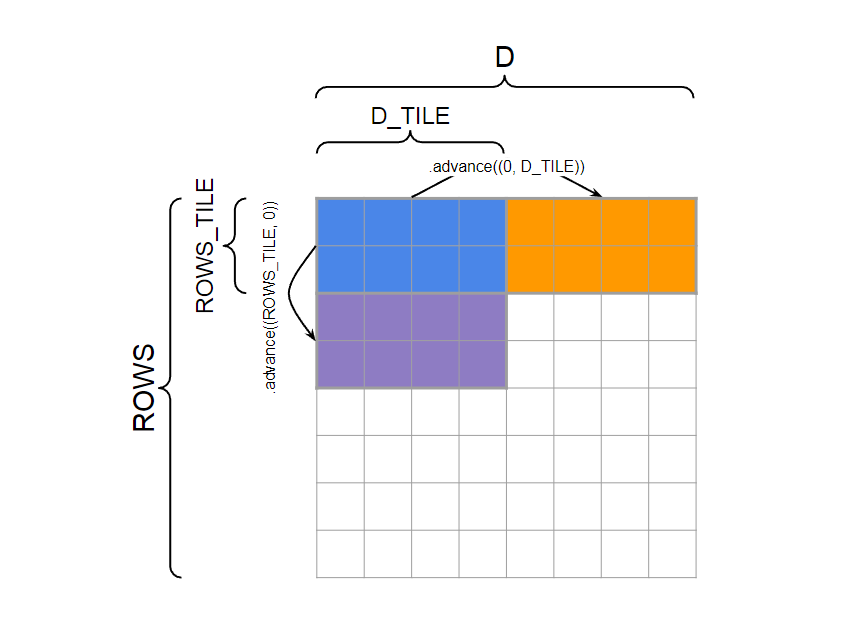

In [ ]:
def weighted_sum(x, weight):
    # Here, assume that x has n-dim shape [..., D], and weight has 1D shape [D]
    return (weight * x).sum(axis=-1)

请参考图上图，了解 tile 的示意图以及如何推进块指针。上述的加权求和函数如下所示

In [ ]:
import triton
import triton.language as tl
from einops import rearrange, einsum
@triton.jit
def weighted_sum_fwd(
    x_ptr, weight_ptr,       # 输入指针
    output_ptr,              # 输出指针
    x_stride_row, x_stride_dim,  # strides 告诉我们如何在张量的每个轴上移动一个元素
    weight_stride_dim,       # 很可能是 1
    output_stride_row,       # 很可能是 1
    ROWS, D,
    ROWS_TILE_SIZE: tl.constexpr, D_TILE_SIZE: tl.constexpr,  # tile 的形状必须在编译时已知
):
    # 每个实例将计算 x 的一块行的加权和
    # `tl.program_id` 给我们一个方法来检查当前线程块的编号
    row_tile_idx = tl.program_id(0)

    # block 指针给我们一个方法，从 ND 内存区域中选择数据
    # 并移动选择位置
    # block 指针必须知道：
    # - 张量第一个元素的指针
    # - 张量的整体形状以处理越界访问
    # - 每个维度的步长，用于使用内存布局属性
    # - 起始块的ND坐标，即“偏移量”
    # - 一次使用/存储的块形状
    # - 内存中主要到次要的维度顺序
    # axes（=np.argsort(strides)）用于优化，特别是在H100上

    x_block_ptr = tl.make_block_ptr(
        x_ptr,
        shape=(ROWS, D,),
        strides=(x_stride_row, x_stride_dim),
        offsets=(row_tile_idx * ROWS_TILE_SIZE, 0),
        block_shape=(ROWS_TILE_SIZE, D_TILE_SIZE),
        order=(1, 0),
    )

    weight_block_ptr = tl.make_block_ptr(
        weight_ptr,
        shape=(D,),
        strides=(weight_stride_dim,),
        offsets=(0,),
        block_shape=(D_TILE_SIZE,),
        order=(0,),
    )

    output_block_ptr = tl.make_block_ptr(
        output_ptr,
        shape=(ROWS,),
        strides=(output_stride_row,),
        offsets=(row_tile_idx * ROWS_TILE_SIZE,),
        block_shape=(ROWS_TILE_SIZE,),
        order=(0,),
    )

    # 初始化一个缓冲区以写入到输出
    output = tl.zeros((ROWS_TILE_SIZE,), dtype=tl.float32)

    for i in range(tl.div(D, D_TILE_SIZE)):
        # 加载当前块指针
        # 由于ROWS_TILE_SIZE可能不能整除ROWS，且D_TILE_SIZE可能不能整除D，
        # 我们需要为两个维度进行边界检查
        row = tl.load(x_block_ptr, boundary_check=(0, 1), padding_option="zero")  # (ROWS_TILE_SIZE, D_TILE_SIZE)
        weight = tl.load(weight_block_ptr, boundary_check=(0,), padding_option="zero")  # (D_TILE_SIZE,)

        # 计算行的加权和。
        output += tl.sum(row * weight[None, :], axis=1)

        # 移动到下一个块。
        # 这些是（行，列）坐标的增量
        x_block_ptr = x_block_ptr.advance((0, D_TILE_SIZE))  # 在最后一个维度移动D_TILE_SIZE
        weight_block_ptr = weight_block_ptr.advance((D_TILE_SIZE,))  # 移动D_TILE_SIZE

        # 将输出写入输出块指针（每行一个标量）
        # 由于ROWS_TILE_SIZE可能不能整除ROWS，我们需要边界检查
        tl.store(output_block_ptr, output, boundary_check=(0,))

# 现在我们将这个内核包装在一个PyTorch自动微分函数中，该函数将与PyTorch（即，接受张量作为输入，输出张量，并在反向传播期间与自动微分引擎一起工作）一起解释
class WeightedSumFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight):
        # 在反向传递中缓存x和weight，当我们
        # 只接收到输出张量的梯度时，将使用它们
        # 需要计算x和weight的梯度。
        D, output_dims = x.shape[-1], x.shape[:-1]

        # 将输入张量重塑为2D
        input_shape = x.shape
        x = rearrange(x, "... d -> (...) d")

        ctx.save_for_backward(x, weight)

        assert len(weight.shape) == 1 and weight.shape[0] == D, "维度不匹配"
        assert x.is_cuda and weight.is_cuda, "期望CUDA张量"
        assert x.is_contiguous(), "我们的指针算术将假设x是连续的"

        ctx.D_TILE_SIZE = triton.next_power_of_2(D) // 16  # 大约16次循环遍历嵌入维度
        ctx.ROWS_TILE_SIZE = 16  # 每个线程同时处理16个批次元素
        ctx.input_shape = input_shape

        # 需要初始化一个空的结果张量。注意这些元素不一定是0！
        y = torch.empty(output_dims, device=x.device)

        # 在我们的1D网格中启动我们的内核，有n个实例。
        n_rows = y.numel()
        weighted_sum_fwd[(triton.cdiv(n_rows, ctx.ROWS_TILE_SIZE),)](
            x, weight,
            y,
            x.stride(0), x.stride(1),
            weight.stride(0),
            y.stride(0),
            ROWS=n_rows, D=D,
            ROWS_TILE_SIZE=ctx.ROWS_TILE_SIZE, D_TILE_SIZE=ctx.D_TILE_SIZE,
        )

        return y.view(input_shape[:-1])

### FlashAttention 中分块与数值稳定 Softmax 为什么能够显著加速

FlashAttention 的加速来源，**并不在于减少了计算量（FLOPs）**，而在于它彻底改变了 attention 的计算路径，使得大量中间结果不再落到显存中。通过分块和流式计算，FlashAttention 将原本以显存读写为主导的计算，转变为主要发生在片上存储中的连续计算过程。

从数学形式上看，FlashAttention 仍然计算的是

$$
\text{softmax}(QK^T)V
$$

但实现方式与标准 Attention 完全不同。

---

### 标准 Attention 的真实开销在哪里

在标准 Attention 中，假设序列长度为 $N$，每个 head 的维度为 $d$。首先需要计算 $QK^T$，这一步的计算复杂度是 $O(N^2 d)$，并且会生成一个大小为 $N \times N$ 的 attention matrix。接下来对这个矩阵做 softmax，需要再次读写整个 $N \times N$ 的结果，最后再与 $V$ 相乘。

从 FLOPs 的角度看，这些操作都是 $O(N^2 d)$ 或 $O(N^2)$，看起来并不离谱。但真正的问题在于，这个 $N \times N$ 的中间矩阵太大，**只能被写入显存（HBM）**。而在 GPU 上，显存带宽远远慢于算力，实际运行时，模型往往是在“等内存”，而不是在“等计算”。

换句话说，标准 Attention 的瓶颈并不是算不动，而是**读写显存的次数和数据量过多**。



### GPU 的存储层级决定了性能上限

GPU 上的存储可以粗略分为三个层级：寄存器速度最快，但容量极小；shared memory 次之，容量有限；显存容量最大，但访问延迟和带宽最差。标准 Attention 中的 $N \times N$ attention matrix 无论如何都放不进片上存储，只能反复写入和读取显存，这直接决定了性能上限。

FlashAttention 的核心设计目标，就是**避免让这个矩阵出现**。



### 分块（blocking）的本质：让数据留在片上

FlashAttention 将 Attention 的计算拆成多个小块。对每一小块 $Q$，它只与当前的 $K/V$ 子块交互，计算局部的 $QK^T$，立刻参与 softmax 的更新，并马上与 $V$ 相乘。整个过程中，从不生成完整的 $N \times N$ attention matrix。

这样一来，局部的中间结果可以一直停留在寄存器或 shared memory 中，用完即丢，不再写入显存。显存中只需要读入 $Q$、$K$、$V$ 的分块数据，并写回最终的输出块。

结果是，显存 I/O 从原来的 $O(N^2)$ 量级，下降到了与输入输出规模相当的 $O(N \cdot d)$。在大模型场景下，这个变化直接决定了数量级上的性能差异。



### 为什么需要“在线”的数值稳定 Softmax

分块之后，新的问题出现了：标准 softmax 的定义要求在计算时看到一整行的 $QK^T$，而这恰恰与“流式计算”相冲突。也就是说，如果仍然使用传统 softmax，就必须先把整行 attention score 算完并存下来，这会把我们重新拉回显存瓶颈。

FlashAttention 使用的是一种**可递推、数值稳定的 softmax 形式**。对于每一行 attention，它不一次性计算最大值和归一化因子，而是在处理每个 block 时，逐步更新当前的最大值 $m_i$ 和归一化累积量 $l_i$。每来一个新的 block，就根据新的局部最大值调整已有的统计量。

对应的递推形式可以写成：

$$
m_i^{(t)} = \max\left(m_i^{(t-1)}, \max_j S_{ij}^{(t)}\right)
$$

$$
l_i^{(t)} =
l_i^{(t-1)} e^{m_i^{(t-1)} - m_i^{(t)}} +
\sum_j e^{S_{ij}^{(t)} - m_i^{(t)}}
$$

这种写法的关键在于：**不需要完整的 $S = QK^T$**，只要当前 block 的分数，就可以安全地更新 softmax 所需的全部信息。这使得 softmax 自然地融入了分块和 streaming 的计算流程。


### 反向传播同样不需要 Attention Matrix

FlashAttention 的设计并不只考虑 forward。在 forward 过程中，它会额外保存每一行的 $\log\sum\exp$（通常记为 $L$），以及最终的输出

$$
O = \text{softmax}(QK^T)V
$$

有了这些量，反向传播时就可以直接重建梯度公式，而不需要显式地保存或重算完整的 attention matrix。例如，对 score 的梯度可以写成：

$$
dS_{ij} = P_{ij}\left(dP_{ij} - D_i\right)
$$

其中 $P_{ij}$ 表示 softmax 概率，$D_i$ 是按行聚合的项。

因此，无论是在 forward 还是 backward 阶段，FlashAttention 都避免了 $N \times N$ 级别的中间结果落入显存。




# 作业七：使用pytorch实现flash attention

In [1]:
import torch

class FlashAttentionAutograd(torch.autograd.Function):
    """
    FlashAttention（forward + backward）

    输入：
        Q: (B, Nq, d)
        K: (B, Nk, d)
        V: (B, Nk, d)

    输出：
        O: (B, Nq, d)
    """

    @staticmethod
    def forward(ctx, Q, K, V):
        B, Nq, d = Q.shape
        Nk = K.shape[1]

        # -----------------------------
        # block size
        # -----------------------------
        Bq = 64  # Query block 的尺寸
        Bk = 64  # Key / Value block 的尺寸

        # 我们将KV矩阵分成一个个小矩阵

        Tq = Nq // Bq  # Q block 数
        Tk = Nk // Bk  # K/V block 数

        scale = d ** -0.5

        # -----------------------------
        # 输出与中间量
        # -----------------------------
        O = torch.zeros_like(Q)              # Attention 输出
        L = torch.zeros(B, Nq, device=Q.device)  # log-sum-exp（给 backward 用）

        # =========================================================
        # 对 batch 维度显式循环
        # =========================================================
        for b in range(B):
            Q_b = Q[b]  # (Nq, d)
            K_b = K[b]  # (Nk, d)
            V_b = V[b]  # (Nk, d)

            # =====================================================
            # 外层循环：Query block
            # =====================================================
            for i in range(Tq):
                q_i = Q_b[i * Bq:(i + 1) * Bq]  # (Bq, d)

                # -----------------------------
                # FlashAttention 核心状态
                # -----------------------------
                m = torch.full((Bq, 1), -float("inf"), device=Q.device)  # running max
                l = torch.zeros((Bq, 1), device=Q.device)               # running sum
                O_acc = torch.zeros((Bq, d), device=Q.device)           # 输出累积（未归一化）

                # =================================================
                # 内层循环：Key / Value block
                # =================================================
                for j in range(Tk):
                    k_j = K_b[j * Bk:(j + 1) * Bk]  # (Bk, d)
                    v_j = V_b[j * Bk:(j + 1) * Bk]  # (Bk, d)

                    # --------------------------------------------
                    # 计算局部 attention score
                    # S_ij = Q_i @ K_j^T / sqrt(d)
                    # --------------------------------------------
                    S = q_i @ k_j.T * scale  # (Bq, Bk)

                    # 当前 block 内，每一行的最大值
                    row_max = S.max(dim=1, keepdim=True).values  # (Bq, 1)

                    # 更新 running max
                    m_new = torch.maximum(m, row_max)

                    # --------------------------------------------
                    # 数值稳定 softmax（FlashAttention 关键）
                    # --------------------------------------------
                    # 旧 block 贡献修正
                    exp_old = torch.exp(m - m_new) * l

                    # 当前 block 的 exp
                    P = torch.exp(S - m_new)

                    # 更新分母
                    l = exp_old + P.sum(dim=1, keepdim=True)

                    # 更新未归一化输出
                    O_acc = (
                        torch.exp(m - m_new) * O_acc +
                        P @ v_j
                    )

                    # 写回 running max
                    m = m_new

                # =================================================
                # block 内 softmax 归一化
                # =================================================
                O_i = O_acc / l  # (Bq, d)

                # log-sum-exp：L = m + log(l)
                L_i = m.squeeze(1) + torch.log(l.squeeze(1))

                # 写回全局输出
                O[b, i * Bq:(i + 1) * Bq] = O_i
                L[b, i * Bq:(i + 1) * Bq] = L_i

        # 保存 backward 所需变量
        ctx.save_for_backward(Q, K, V, O, L)
        ctx.scale = scale
        ctx.Bq = Bq
        ctx.Bk = Bk

        return O
    
    @staticmethod
    def backward(ctx, dO):
        Q, K, V, O, L = ctx.saved_tensors
        scale = ctx.scale
        Bq = ctx.Bq
        Bk = ctx.Bk

        B, Nq, d = Q.shape
        Nk = K.shape[1]

        Tq = Nq // Bq
        Tk = Nk // Bk

        # --------------------------------------------
        # FlashAttention backward 中的重要中间量
        # D_i = sum_j O_ij * dO_ij
        # --------------------------------------------
        D = torch.sum(O * dO, dim=-1)  # (B, Nq)

        dQ = torch.zeros_like(Q)
        dK = torch.zeros_like(K)
        dV = torch.zeros_like(V)

        for b in range(B):
            for i in range(Tq):
                q_i = Q[b, i * Bq:(i + 1) * Bq]
                dO_i = dO[b, i * Bq:(i + 1) * Bq]
                L_i = L[b, i * Bq:(i + 1) * Bq]
                D_i = D[b, i * Bq:(i + 1) * Bq]

                for j in range(Tk):
                    k_j = K[b, j * Bk:(j + 1) * Bk]
                    v_j = V[b, j * Bk:(j + 1) * Bk]

                    # --------------------------------------------
                    # 重算局部 attention 概率 P_ij
                    # P_ij = exp(S_ij - L_i)
                    # --------------------------------------------
                    S = q_i @ k_j.T * scale
                    P = torch.exp(S - L_i.unsqueeze(1))

                    # -------- dV --------
                    dV[b, j * Bk:(j + 1) * Bk] += P.T @ dO_i

                    # -------- dS --------
                    dP = dO_i @ v_j.T
                    dS = P * (dP - D_i.unsqueeze(1))

                    # -------- dQ --------
                    dQ[b, i * Bq:(i + 1) * Bq] += dS @ k_j * scale

                    # -------- dK --------
                    dK[b, j * Bk:(j + 1) * Bk] += dS.T @ q_i * scale

        return dQ, dK, dV


In [2]:
from my_profile import benchmark,profile 
def test_flash_attention(B=1, N=1024, d=64, device="cuda"):
    torch.manual_seed(0)

    Q = torch.randn(B, N, d, device=device, requires_grad=True)
    K = torch.randn(B, N, d, device=device, requires_grad=True)
    V = torch.randn(B, N, d, device=device, requires_grad=True)

    def run():
        O = FlashAttentionAutograd.apply(Q, K, V)
        #loss = O.sum()
        #loss.backward()

    t = benchmark(description= 'test_flash_attention',run = run)
    t1 = profile(description ='test_flash_attention' , run = run, num_warmups = 3, with_stack = True)
    
    print(f"[FlashAttention] B={B}, N={N}, d={d}, time={t*1000:.3f} ms")
    print(t1)



def naive_attention(Q, K, V):
    d = Q.size(-1)
    scores = Q @ K.transpose(-2, -1) / (d ** 0.5)
    P = torch.softmax(scores, dim=-1)
    return P @ V
def test_naive_attention(B=1, N=1024, d=64, device="cuda"):
    torch.manual_seed(0)

    Q = torch.randn(B, N, d, device=device, requires_grad=True)
    K = torch.randn(B, N, d, device=device, requires_grad=True)
    V = torch.randn(B, N, d, device=device, requires_grad=True)

    def run():
        O = naive_attention(Q, K, V)
        #loss = O.sum()
        #loss.backward()

    t = benchmark(description= 'test_attention',run = run)
    t1 = profile(description ='test_attention' , run = run, num_warmups = 3, with_stack = True)
    print(f"[NaiveAttention]  B={B}, N={N}, d={d}, time={t*1000:.3f} ms")
    print(t1)


device = "cuda"

for N in [1024]:
    test_flash_attention(B=1, N=N, d=64, device=device)
    test_naive_attention(B=1, N=N, d=64, device=device)
    print("-" * 50)


现在真正计时!
单次耗时：58.657169342041016ms
正在使用 cuda
[FlashAttention] B=1, N=1024, d=64, time=58657.169 ms
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                        aten::mm         7.45%       9.324ms        14.19%      17.766ms      34.699us       2.847ms        37.21%       2.847ms       5.560us           512  
void at::

# 2. Triton 内核实现flash attention

Triton 是一个用 Python 写 GPU kernel 的 DSL，本质上是“显式控制数据分块与内存层级的编程模型”，它不是NumPy，也不是高层 PyTorch API，它是一个 CUDA kernel 的“可读版本”。

In [1]:
# from sympy import Q
import torch
import triton
import triton.language as tl

@triton.jit
def flash_attention_fwd_kernel(
    # -------- 全局内存指针 --------
    Q_ptr, K_ptr, V_ptr,           # 输入 Q, K, V
    O_ptr, L_ptr,                  # 输出 O, logsumexp L

    # -------- stride 信息（用于 block ptr）--------
    stride_qb, stride_qn, stride_qd,
    stride_kb, stride_kn, stride_kd,
    stride_vb, stride_vn, stride_vd,
    stride_ob, stride_on, stride_od,
    stride_lb, stride_ln,

    # -------- 序列长度 --------
    Nq, Nk,

    # -------- scale --------
    scale,

    # -------- 编译期常量 --------
    D: tl.constexpr,
    Q_BLOCK: tl.constexpr,
    K_BLOCK: tl.constexpr,
    is_causal: tl.constexpr,
):
    """
    每个 Triton program 负责：
        - 一个 batch
        - 一个 Query block（Q_BLOCK 行）
    """

    # ------------------------------------------------
    # Triton 并行索引
    # ------------------------------------------------
    q_block_id = tl.program_id(0)     # 第几个 Q block
    batch_id   = tl.program_id(1)     # 第几个 batch

    # =================================================
    # 构造 block pointer（这是 Triton 的关键）
    # =================================================
    Q_block_ptr = tl.make_block_ptr(
        base=Q_ptr + batch_id * stride_qb,
        shape=(Nq, D),
        strides=(stride_qn, stride_qd),
        offsets=(q_block_id * Q_BLOCK, 0),
        block_shape=(Q_BLOCK, D),
        order=(1, 0),
    )

    #  K / V 从第 0 行开始，后面在 loop 中 advance
    K_block_ptr = tl.make_block_ptr(
        base=K_ptr + batch_id * stride_kb,
        shape=(Nk, D),
        strides=(stride_kn, stride_kd),
        offsets=(0, 0),
        block_shape=(K_BLOCK, D),
        order=(1, 0),
    )

    V_block_ptr = tl.make_block_ptr(
        base=V_ptr + batch_id * stride_vb,
        shape=(Nk, D),
        strides=(stride_vn, stride_vd),
        offsets=(0, 0),
        block_shape=(K_BLOCK, D),
        order=(1, 0),
    )

    O_block_ptr = tl.make_block_ptr(
        base=O_ptr + batch_id * stride_ob,
        shape=(Nq, D),
        strides=(stride_on, stride_od),
        offsets=(q_block_id * Q_BLOCK, 0),
        block_shape=(Q_BLOCK, D),
        order=(1, 0),
    )

    L_block_ptr = tl.make_block_ptr(
        base=L_ptr + batch_id * stride_lb,
        shape=(Nq, 1),
        strides=(stride_ln, 1),
        offsets=(q_block_id * Q_BLOCK, 0),
        block_shape=(Q_BLOCK, 1),
        order=(1, 0),
    )

    # =================================================
    # 加载 Query block
    # =================================================
    Q_i = tl.load(Q_block_ptr)  # (Q_BLOCK, D)

    # =================================================
    # FlashAttention 核心状态（每个 Q block 独立）
    # =================================================
    O_acc = tl.zeros((Q_BLOCK, D), dtype=tl.float32)       # 未归一化输出累积
    L_acc = tl.zeros((Q_BLOCK, 1), dtype=tl.float32)      # softmax 分母
    M_acc = tl.full((Q_BLOCK, 1), -float("inf"), tl.float32)  # running max

    # =================================================
    # 内层循环：遍历所有 K/V block
    # =================================================
    for k_block_id in range(tl.cdiv(Nk, K_BLOCK)):
        K_j = tl.load(K_block_ptr)   # (K_BLOCK, D)
        V_j = tl.load(V_block_ptr)   # (K_BLOCK, D)

        # ---------------------------------------------
        # S_ij = Q_i @ K_j^T / sqrt(d)
        # ---------------------------------------------
        S_ij = tl.dot(Q_i, K_j.T) * scale  # (Q_BLOCK, K_BLOCK)

        # ---------------------------------------------
        # Causal mask（编译期 if）
        # ---------------------------------------------
        if is_causal:
            q_idx = q_block_id * Q_BLOCK + tl.arange(0, Q_BLOCK)[:, None]
            k_idx = k_block_id * K_BLOCK + tl.arange(0, K_BLOCK)[None, :]
            causal_mask = q_idx >= k_idx
            S_ij = tl.where(causal_mask, S_ij, -1e6)

        # ---------------------------------------------
        # 数值稳定 softmax（FlashAttention 核心）
        # ---------------------------------------------
        M_block = tl.max(S_ij, axis=1, keep_dims=True)
        M_new = tl.maximum(M_acc, M_block)

        P_ij = tl.exp(S_ij - M_block)

        L_new = (
            tl.exp(M_acc - M_new) * L_acc +
            tl.exp(M_block - M_new) * tl.sum(P_ij, axis=1, keep_dims=True)
        )

        # 类型对齐（Triton 细节）
        P_cast = P_ij.to(V_block_ptr.type.element_ty)

        O_new = (
            tl.exp(M_acc - M_new) * O_acc +
            tl.exp(M_block - M_new) * tl.dot(P_cast, V_j)
        )

        # ---------------------------------------------
        # 更新 running 状态
        # ---------------------------------------------
        M_acc = M_new
        L_acc = L_new
        O_acc = O_new

        # ---------------------------------------------
        # 移动 K/V block 指针
        # ---------------------------------------------
        K_block_ptr = K_block_ptr.advance((K_BLOCK, 0))
        V_block_ptr = V_block_ptr.advance((K_BLOCK, 0))

    # =================================================
    # softmax 归一化
    # =================================================
    O_i = O_acc / L_acc
    L_i = M_acc + tl.log(L_acc)

    tl.store(O_block_ptr, O_i)
    tl.store(L_block_ptr, L_i)

@triton.jit
def flash_bwd_kernel(
    Q_ptr, K_ptr, V_ptr, O_ptr, L_ptr, dO_ptr, D_ptr,
    dQ_ptr, dK_ptr, dV_ptr,
    stride_qb, stride_qq, stride_qd,
    stride_kb, stride_kk, stride_kd,
    stride_vb, stride_vk, stride_vd,
    stride_ob, stride_oq, stride_od,
    stride_lb, stride_lq,
    stride_dob, stride_doq, stride_dod,
    stride_db, stride_dq_d,
    N_QUERIES, N_KEYS,
    scale,
    D: tl.constexpr,
    Q_TILE_SIZE: tl.constexpr,
    K_TILE_SIZE: tl.constexpr,
    is_causal: tl.constexpr,
):
    # program ids
    k_tile_id = tl.program_id(0)
    batch_id = tl.program_id(1)

    # -------------------------
    # block pointers (Q-side)
    # -------------------------
    Q_block_ptr = tl.make_block_ptr(
        base=Q_ptr + batch_id * stride_qb,
        shape=(N_QUERIES, D),
        strides=(stride_qq, stride_qd),
        offsets=(0, 0),
        block_shape=(Q_TILE_SIZE, D),
        order=(1, 0),
    )
    O_block_ptr = tl.make_block_ptr(
        O_ptr + batch_id * stride_ob,
        shape=(N_QUERIES, D),
        strides=(stride_oq, stride_od),
        offsets=(0, 0),
        block_shape=(Q_TILE_SIZE, D),
        order=(1, 0),
    )
    dO_block_ptr = tl.make_block_ptr(
        dO_ptr + batch_id * stride_dob,
        shape=(N_QUERIES, D),
        strides=(stride_doq, stride_dod),
        offsets=(0, 0),
        block_shape=(Q_TILE_SIZE, D),
        order=(1, 0),
    )
    L_block_ptr = tl.make_block_ptr(
        L_ptr + batch_id * stride_lb,
        shape=(N_QUERIES, 1),
        strides=(stride_lq, 1),
        offsets=(0, 0),
        block_shape=(Q_TILE_SIZE, 1),
        order=(1, 0),
    )
    D_block_ptr = tl.make_block_ptr(
        D_ptr + batch_id * stride_db,
        shape=(N_QUERIES, 1),
        strides=(stride_dq_d, 1),
        offsets=(0, 0),
        block_shape=(Q_TILE_SIZE, 1),
        order=(1, 0),
    )

    # -------------------------
    # block pointers (K/V-side)
    # -------------------------
    K_block_ptr = tl.make_block_ptr(
        K_ptr + batch_id * stride_kb,
        shape=(N_KEYS, D),
        strides=(stride_kk, stride_kd),
        offsets=(k_tile_id * K_TILE_SIZE, 0),
        block_shape=(K_TILE_SIZE, D),
        order=(1, 0),
    )
    V_block_ptr = tl.make_block_ptr(
        V_ptr + batch_id * stride_vb,
        shape=(N_KEYS, D),
        strides=(stride_vk, stride_vd),
        offsets=(k_tile_id * K_TILE_SIZE, 0),
        block_shape=(K_TILE_SIZE, D),
        order=(1, 0),
    )
    dK_block_ptr = tl.make_block_ptr(
        dK_ptr + batch_id * stride_kb,
        shape=(N_KEYS, D),
        strides=(stride_kk, stride_kd),
        offsets=(k_tile_id * K_TILE_SIZE, 0),
        block_shape=(K_TILE_SIZE, D),
        order=(1, 0),
    )
    dV_block_ptr = tl.make_block_ptr(
        dV_ptr + batch_id * stride_vb,
        shape=(N_KEYS, D),
        strides=(stride_vk, stride_vd),
        offsets=(k_tile_id * K_TILE_SIZE, 0),
        block_shape=(K_TILE_SIZE, D),
        order=(1, 0),
    )

    # -------------------------
    # load K/V tile
    # -------------------------
    K_j = tl.load(K_block_ptr)  # (K_TILE_SIZE, D)
    V_j = tl.load(V_block_ptr)

    dK_j = tl.zeros((K_TILE_SIZE, D), dtype=tl.float32)
    dV_j = tl.zeros((K_TILE_SIZE, D), dtype=tl.float32)

    # -------------------------
    # loop over Q tiles
    # -------------------------
    for q_tile_id in range(tl.cdiv(N_QUERIES, Q_TILE_SIZE)):
        Q_i = tl.load(Q_block_ptr)
        O_i = tl.load(O_block_ptr)
        dO_i = tl.load(dO_block_ptr)
        L_i = tl.load(L_block_ptr)
        D_i = tl.load(D_block_ptr)

        # S = QK^T
        S_ij = tl.dot(Q_i, K_j.T) * scale

        if is_causal:
            q_idx = q_tile_id * Q_TILE_SIZE + tl.arange(0, Q_TILE_SIZE)[:, None]
            k_idx = k_tile_id * K_TILE_SIZE + tl.arange(0, K_TILE_SIZE)[None, :]
            S_ij = tl.where(q_idx >= k_idx, S_ij, -1e6)

        # P = softmax
        P_ij = tl.exp(S_ij - L_i)

        # dV
        dV_j += tl.dot(P_ij.to(V_j.dtype).T, dO_i)

        # dP
        dP_ij = tl.dot(dO_i, V_j.T)

        # dS
        dS_ij = P_ij * (dP_ij - D_i)
        dS_ij = dS_ij * scale

        # dQ (atomic add)
        dQ_i = tl.dot(dS_ij, K_j)

        q_idx = q_tile_id * Q_TILE_SIZE + tl.arange(0, Q_TILE_SIZE)[:, None]
        d_idx = tl.arange(0, D)[None, :]
        mask = (q_idx < N_QUERIES) & (d_idx < D)
        dq_ptrs = dQ_ptr + batch_id * stride_qb + q_idx * stride_qq + d_idx * stride_qd
        tl.atomic_add(dq_ptrs, dQ_i.to(dQ_ptr.dtype.element_ty), mask=mask)

        # dK
        dK_j += tl.dot(dS_ij.T, Q_i)

        # advance Q-side blocks
        Q_block_ptr = Q_block_ptr.advance((Q_TILE_SIZE, 0))
        O_block_ptr = O_block_ptr.advance((Q_TILE_SIZE, 0))
        dO_block_ptr = dO_block_ptr.advance((Q_TILE_SIZE, 0))
        L_block_ptr = L_block_ptr.advance((Q_TILE_SIZE, 0))
        D_block_ptr = D_block_ptr.advance((Q_TILE_SIZE, 0))

    # -------------------------
    # store dK / dV
    # -------------------------
    tl.store(dK_block_ptr, dK_j.to(dK_ptr.dtype.element_ty))
    tl.store(dV_block_ptr, dV_j.to(dV_ptr.dtype.element_ty))



class FlashAttentionTriton(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Q, K, V, is_causal=False):
        """
        Q, K, V: (B, N, D)
        """

        B, Nq, D = Q.shape
        Nk = K.shape[1]

        Q_BLOCK = 16
        K_BLOCK = 16

        scale = D ** -0.5

        O = torch.empty_like(Q)
        L = torch.empty(B, Nq, device=Q.device)

        grid = (Nq // Q_BLOCK, B)

        flash_attention_fwd_kernel[grid](
            Q, K, V, O, L,
            Q.stride(0), Q.stride(1), Q.stride(2),
            K.stride(0), K.stride(1), K.stride(2),
            V.stride(0), V.stride(1), V.stride(2),
            O.stride(0), O.stride(1), O.stride(2),
            L.stride(0), L.stride(1),
            Nq, Nk,
            scale,
            D=D,
            Q_BLOCK=Q_BLOCK,
            K_BLOCK=K_BLOCK,
            is_causal=is_causal,
        )

        ctx.save_for_backward(Q, K, V, O, L)
        ctx.is_causal = is_causal
        return O
    @staticmethod
    def backward(ctx, do):
        q, k, v, o, l = ctx.saved_tensors
        is_causal = ctx.is_causal
    
        B, Nq, D = q.shape
        Nk = k.shape[1]
    
        Bq = 16
        Bk = 16
        scale = D ** -0.5
    
        dq = torch.zeros_like(q)
        dk = torch.zeros_like(k)
        dv = torch.zeros_like(v)
    
        # D_i = sum_j dO_ij * O_ij
        D_sum = torch.sum(o * do, dim=-1, keepdim=True)
    
        grid = (triton.cdiv(Nk, Bk), B)
    
        flash_bwd_kernel[grid](
            q, k, v, o, l, do, D_sum,
            dq, dk, dv,
            q.stride(0), q.stride(1), q.stride(2),
            k.stride(0), k.stride(1), k.stride(2),
            v.stride(0), v.stride(1), v.stride(2),
            o.stride(0), o.stride(1), o.stride(2),
            l.stride(0), l.stride(1),
            do.stride(0), do.stride(1), do.stride(2),
            D_sum.stride(0), D_sum.stride(1),
            Nq, Nk,
            scale,
            D=D,
            Q_TILE_SIZE=Bq,
            K_TILE_SIZE=Bk,
            is_causal=is_causal,
        )
    
        return dq, dk, dv, None
    


In [2]:
import torch
import time
import gc

def benchmark_attention_flash(device="cuda"):
    torch.manual_seed(0)
    
    batch_size = 8
    d_models = [16, 32, 64, 128]
    seqlens = [256, 1024, 4096, 8192, 16384]
    
    results = []
    
    for d_model in d_models:
        print(f"\n{'='*50}")
        print(f"Testing d_model={d_model}")
        print(f"{'='*50}")
        
        for seqlen in seqlens:
            try:
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
                
                # 构造输入（无多头）
                Q = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True)
                K = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True)
                V = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True)
                
                # Warm-up：包含 forward + backward，确保缓存预热
                for _ in range(10):
                    out = FlashAttentionTriton.apply(Q, K, V)
                    loss = out.sum()
                    loss.backward()
                    # 清零梯度，避免累积
                    Q.grad = None
                    K.grad = None
                    V.grad = None
                
                torch.cuda.synchronize()
                
                # Forward timing（无梯度）
                with torch.no_grad():
                    start = time.perf_counter()
                    for _ in range(100):
                        out = FlashAttentionTriton.apply(Q, K, V)
                    torch.cuda.synchronize()
                    forward_time = (time.perf_counter() - start) / 100
                
                # 记录 forward 后的峰值内存（作为参考）
                mem_allocated = torch.cuda.max_memory_allocated() / 1024**2
                
                # Backward timing
                start = time.perf_counter()
                for _ in range(100):
                    out = FlashAttentionTriton.apply(Q, K, V)
                    loss = out.sum()
                    loss.backward()
                    # 清零梯度
                    Q.grad = None
                    K.grad = None
                    V.grad = None
                torch.cuda.synchronize()
                backward_time = (time.perf_counter() - start) / 100
                
                results.append({
                    "d_model": d_model,
                    "seqlen": seqlen,
                    "forward_ms": forward_time * 1000,
                    "backward_ms": backward_time * 1000,
                    "total_ms": (forward_time + backward_time) * 1000,
                    "mem_MB": mem_allocated,
                })
                
                print(f"✓ T={seqlen:5d} | Fwd: {forward_time*1000:6.2f}ms | Bwd: {backward_time*1000:7.2f}ms | Peak Mem: {mem_allocated:.1f}MB")
                
            except RuntimeError as e:
                if "out of memory" in str(e):
                    results.append({
                        "d_model": d_model,
                        "seqlen": seqlen,
                        "OOM": True
                    })
                    print(f"✗ T={seqlen:5d} | OOM")
                    torch.cuda.empty_cache()
                else:
                    raise e
            
            # 清理显存
            del Q, K, V
            try:
                del out, loss
            except NameError:
                pass
            torch.cuda.empty_cache()
        
        gc.collect()
        torch.cuda.empty_cache()
    
    return results

# 运行
results = benchmark_attention_flash()


Testing d_model=16
✓ T=  256 | Fwd:   0.04ms | Bwd:    0.55ms | Peak Mem: 1.0MB
✓ T= 1024 | Fwd:   0.24ms | Bwd:    0.99ms | Peak Mem: 4.1MB
✓ T= 4096 | Fwd:   3.30ms | Bwd:   13.12ms | Peak Mem: 16.3MB
✓ T= 8192 | Fwd:  13.45ms | Bwd:   48.18ms | Peak Mem: 32.5MB
✓ T=16384 | Fwd:  52.95ms | Bwd:  205.94ms | Peak Mem: 65.0MB

Testing d_model=32
✓ T=  256 | Fwd:   0.05ms | Bwd:    0.48ms | Peak Mem: 65.0MB
✓ T= 1024 | Fwd:   0.29ms | Bwd:    1.20ms | Peak Mem: 65.0MB
✓ T= 4096 | Fwd:   4.47ms | Bwd:   17.61ms | Peak Mem: 65.0MB
✓ T= 8192 | Fwd:  16.74ms | Bwd:   66.03ms | Peak Mem: 65.0MB
✓ T=16384 | Fwd:  65.42ms | Bwd:  258.39ms | Peak Mem: 129.0MB

Testing d_model=64
✓ T=  256 | Fwd:   0.06ms | Bwd:    0.51ms | Peak Mem: 129.0MB
✓ T= 1024 | Fwd:   0.39ms | Bwd:    2.33ms | Peak Mem: 129.0MB
✓ T= 4096 | Fwd:   5.85ms | Bwd:   32.14ms | Peak Mem: 129.0MB
✓ T= 8192 | Fwd:  22.12ms | Bwd:  139.88ms | Peak Mem: 129.0MB
✓ T=16384 | Fwd:  94.88ms | Bwd:  550.40ms | Peak Mem: 257.0MB

Testi

如果报错out of resource: shared memory, Required: 115200, Hardware limit: 101376. Reducing block sizes or num_stages may help.

适当将Q_BLOCK = 16 和 K_BLOCK = 16还有Bq = 16 ，Bk = 16调低，如果你的GPU非常给力，也可以适当调高，我用的是4060 -8G（笔记本）

In [3]:
from my_profile import benchmark,profile
def test_flash_AttentionTriton(B=4, N=4096, d=64, device="cuda"):
    torch.manual_seed(0)

    Q = torch.randn(B, N, d, device=device, requires_grad=True)
    K = torch.randn(B, N, d, device=device, requires_grad=True)
    V = torch.randn(B, N, d, device=device, requires_grad=True)

    def run():
        O = FlashAttentionTriton.apply(Q, K, V)
        loss = O.sum()
        loss.backward()

    t = benchmark(description= 'FlashAttentionTriton',run = run)
    t1 = profile(description ='FlashAttentionTriton' , run = run, num_warmups = 3, with_stack = True)
    
    print(f"[FlashAttentionTriton] B={B}, N={N}, d={d}, time={t*1000:.3f} ms")
    print(t1)


In [4]:
test_flash_AttentionTriton()

现在真正计时!
单次耗时：19.52393849690755ms
正在使用 cuda
[FlashAttentionTriton] B=4, N=4096, d=64, time=19523.938 ms
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                    FlashAttentionTritonBackward         1.67%     307.833us         2.47%     456.115us     456.115us      13.734ms        82.53%      13.775ms      13.775ms             1  
    

下面是按你要求改写后的版本：整体改为连贯叙述，弱化“讲义/条目式”结构，减少无序列表，强调概念之间的因果关系和工程语境，读起来更像一篇技术说明而不是 AI 教程。

---

# Triton 的一般语法与编程模型说明

Triton 是一种面向深度学习算子的领域专用语言（DSL）。它的目标并不是取代 PyTorch，而是在不直接编写 CUDA 的情况下，让开发者依然能够对 GPU 上的并行方式和内存访问模式进行精细控制。可以把 Triton 理解为介于高层框架与底层 CUDA 之间的一层：它保留了 Python 的表达方式，但暴露了足够多的硬件语义，使性能优化成为可能。

---

## 一、program：Triton 中最核心的并行抽象

在 Triton 中，最基本的执行单元叫作 program。每个 program 都可以通过

```python
pid = tl.program_id(axis)
```

获取自己在某一个并行维度上的编号。从映射关系上看，program 大致对应 CUDA 中的 thread block，而 `tl.program_id(axis)` 则类似于 `blockIdx.x` 或 `blockIdx.y`。

不过，Triton 的 program 与 CUDA block 有一个本质差异：它天然是向量化的。一个 program 并不是在处理单个标量元素，而是负责一整块数据，也就是一个 tile。也正因为如此，在 Triton 中进行思考时，基本单位不再是“线程”，而是“一个 program 对应一块数据”。

---

## 二、grid：显式声明并行的组织方式

在调用 Triton kernel 时，常见的形式是：

```python
kernel[grid](...)
```

这里的 `grid` 本质上定义了要启动多少个 program，以及这些 program 在多个并行维度上的排列方式。`grid` 是一个多维元组，对应的每一个维度都可以通过 `tl.program_id(0)`、`tl.program_id(1)` 等方式在 kernel 内部访问。

在实际使用中，开发者通常会把不同的 axis 映射为不同的语义维度，比如行块、batch 或 attention head。Triton 并不关心底层启动了多少线程，它关心的是一共启动了多少个 program，以及每个 program 负责处理哪一块逻辑数据。

---

## 三、Triton 的内存访问模型

在 Triton kernel 内部，所有传入的张量参数本质上都是裸指针，例如 `Q_ptr`、`K_ptr`、`V_ptr`。这些指针只包含内存地址，本身并不携带 shape 或 stride 等信息。因此，Triton 要求开发者显式地描述张量的逻辑形状、内存布局以及当前 program 应该访问的区域。

为了完成这一点，Triton 提供了 `tl.make_block_ptr` 这一关键抽象：

```python
block_ptr = tl.make_block_ptr(
    base,
    shape,
    strides,
    offsets,
    block_shape,
    order
)
```

这一步并不是简单的语法封装，而是在定义一个“可以被向量化加载和存储的二维 tile”。通过 `shape` 和 `strides` 描述整个张量的逻辑结构，再结合 `offsets` 和 `block_shape`，Triton 就能够明确当前 program 对应的是哪一块数据。`order` 则会影响内存访问顺序，从而决定是否能够实现良好的内存合并访问。

一旦构造了 `block_ptr`，后续的 `tl.load` 和 `tl.store` 就会变成一次对齐的、向量化的内存操作，这也是 Triton 能够写出高性能 kernel 的基础。

---

## 四、Triton 中“张量”的真实含义

需要注意的是，Triton 中的“张量”并不是 PyTorch 的 Tensor，而是编译期 shape 已知的寄存器向量。例如：

```python
x = tl.zeros((BLOCK_M, BLOCK_N), dtype=tl.float32)
```

这里的 `BLOCK_M` 和 `BLOCK_N` 必须在编译期就确定下来。这样的张量通常存放在寄存器或片上 SRAM 中，所有计算都是逐元素或按块展开的。这也是为什么 Triton 对很多参数都有 `tl.constexpr` 的要求。

---

## 五、tl.constexpr：为什么编译期常量如此重要

当一个参数被标记为 `tl.constexpr` 时，意味着它在 kernel 编译阶段就是已知的常量，而不是运行时再传入的值。对于 Triton 来说，这一点至关重要，因为 block 的 shape、循环展开方式、向量化宽度以及内存布局，都依赖这些值进行静态推导。

经验上可以这样理解：凡是会影响 shape、循环次数或内存访问模式的参数，都必须是 `constexpr`；而仅仅参与数值缩放或计算的参数，则可以作为运行时变量存在。

---

## 六、算子语义：没有 Python 循环的逐元素并行

Triton 中的运算本质上都是逐元素并行的。比如：

```python
x = tl.arange(0, BLOCK)
```

生成的并不是一个标量，而是一个向量 `[0, 1, 2, ..., BLOCK-1]`。类似地，表达式

```python
mask = q_idx >= k_idx
```

产生的是一个布尔矩阵，而不是单个判断结果。

`tl.where` 的语义也是完全向量化的：对每一个位置独立地选择结果，而不是像 Python 那样进行控制流分支。

---

## 七、控制流：为什么 Triton 不鼓励数据相关的 if

在 Triton 中，`if` 语句只有在条件是 `tl.constexpr` 时才是安全的。原因在于 Triton kernel 在本质上是一段静态程序，所有 program 都必须执行相同的指令流。如果控制流依赖于数据，就会破坏这种一致性。

因此，与配置相关的分支可以通过 `constexpr if` 在编译期解决，而与数据相关的分支则必须通过 mask 来表达。这也是为什么 causal mask 需要写成 `tl.where(mask, S, -inf)`，而不能直接使用基于索引关系的 `if` 判断。

---

## 八、数学运算与矩阵乘法支持

Triton 提供了 `tl.dot` 作为块级矩阵乘法的原语。它接受 `(M, K)` 和 `(K, N)` 形状的输入，输出 `(M, N)` 的结果，并在数据类型和 shape 合适的情况下自动映射到 tensor core。这一能力是实现 FlashAttention、GEMM 以及多种融合算子的基础。

在广播行为上，Triton 与 NumPy 或 PyTorch 的规则基本一致，但前提是所有相关的 shape 都必须在编译期可以推导出来。例如，在已知 axis 和维度的情况下，`tl.max(..., keep_dims=True)` 是完全合法的。

---

## 九、Triton kernel 与 PyTorch Autograd 的分工

Triton kernel 本身并不关心梯度，也不会保存中间状态。因此，在实际工程中，通常会把 Triton kernel 包裹在一个自定义的 `torch.autograd.Function` 中。前向阶段负责调用 Triton kernel 并保存必要的张量，反向阶段再调用对应的 Triton kernel 计算梯度。

在这种结构下，Triton 专注于高性能数值计算，而 PyTorch 负责计算图管理和调度，两者的职责边界非常清晰。
